# FrameAxis Analysis

In this notebook the process of calculating the FrameAxis values are explained, furthmore the FrameAxis values are evluated for the given datasets.

## Documentation

### 1. Microframe Design

In the following the selection of the seed words for from the eMFT is described. We select the top 40 words for each foundation-sentiment pair based on the highest propability. The seed words are selected from the eMFT dataset.

In [1]:
import pandas as pd

# load csv file from ../../data/axis/mft_raw.csv
df = pd.read_csv('../../data/axis/mft_filtered.csv')

df.head()

word  care_hlcts  fairness_hlcts  loyalty_hlcts  authority_hlcts  \
0      liked         0.0             1.0            5.0              2.0   
1  successor         2.0             2.0            9.0              2.0   
2  effective        15.0             9.0            4.0             11.0   
3  agreement        13.0            20.0           27.0             11.0   
4        fit         2.0             3.0            2.0              4.0   

   sanctity_hlcts  total_seen  seen_care  seen_fairness  seen_loyalty  ...  \
0             2.0       107.0       17.0           21.0          29.0  ...   
1             2.0       192.0       35.0           43.0          46.0  ...   
2            10.0       487.0      100.0          109.0          80.0  ...   
3             7.0       930.0      199.0          219.0         224.0  ...   
4             5.0       208.0       59.0           31.0          36.0  ...   

   fairness.virtue  loyalty.virtue  authority.virtue  sanctity.virtue  \
0         0.047619        0.172414          0.086957         0.117647   
1         0.046512        0.195652          0.066667         0.052632   
2         0.082569        0.050000          0.095652         0.120482   
3         0.091324        0.120536          0.079710         0.046667   
4         0.096774        0.055556          0.083333         0.138889   

   care.vice  fairness.vice  loyalty.vice  authority.vice  sanctity.vice  \
0        0.0            0.0           0.0             0.0            0.0   
1        0.0            0.0           0.0             0.0            0.0   
2        0.0            0.0           0.0             0.0            0.0   
3        0.0            0.0           0.0             0.0            0.0   
4        0.0            0.0           0.0             0.0            0.0   

        foundation  
0   loyalty.virtue  
1   loyalty.virtue  
2      care.virtue  
3   loyalty.virtue  
4  sanctity.virtue  

[5 rows x 55 columns]

In [2]:
# Creating the 'foundation' column
df['foundation'] = df[['care_p', 'fairness_p', 'loyalty_p', 'authority_p', 'sanctity_p']].idxmax(axis=1).str.replace('_p', '')

# Extracting the highest value sentiment for each row based on 'foundation' and classifying it as 'vice' or 'virtue'
df['sentiment'] = df.apply(lambda row: 'vice' if row[row['foundation'] + '_sent'] < 0 else 'virtue', axis=1)

In [3]:
df[df["word"] == "liked"]

word  care_hlcts  fairness_hlcts  loyalty_hlcts  authority_hlcts  \
0  liked         0.0             1.0            5.0              2.0   

   sanctity_hlcts  total_seen  seen_care  seen_fairness  seen_loyalty  ...  \
0             2.0       107.0       17.0           21.0          29.0  ...   

   loyalty.virtue  authority.virtue  sanctity.virtue  care.vice  \
0        0.172414          0.086957         0.117647        0.0   

   fairness.vice  loyalty.vice  authority.vice  sanctity.vice  foundation  \
0            0.0           0.0             0.0            0.0     loyalty   

   sentiment  
0     virtue  

[1 rows x 56 columns]

In [4]:
def get_top_n_words(df, n=3):
    # Grouping by foundation and sentiment, then apply a function to get the top n words by '_p' value within each group
    grouped = df.groupby(['foundation', 'sentiment'])
    top_n_dict = {}

    for name, group in grouped:
        foundation, sentiment = name
        # Sorting the group by '_p' value associated with the foundation and slicing the top n
        top_words = group.nlargest(n, f"{foundation}_p")['word'].tolist()
        
        # Build the nested dictionary
        if foundation not in top_n_dict:
            top_n_dict[foundation] = {}
        top_n_dict[foundation][sentiment] = top_words

    return top_n_dict

# Get the top 3 words for each foundation-sentiment combination from the enlarged dataset
top_n_words = get_top_n_words(df, n=40)
top_n_words

{'authority': {'vice': ['protested',
   'rebellion',
   'protesting',
   'revenge',
   'rage',
   'violate',
   'accuse',
   'contempt',
   'intimidation',
   'refused',
   'disruption',
   'riot',
   'launched',
   'prosecuted',
   'beating',
   'protesters',
   'condemned',
   'demanding',
   'disagreed',
   'suspicion',
   'protest',
   'rebels',
   'backed',
   'perpetrators',
   'threatens',
   'terrorists',
   'criticized',
   'hostile',
   'rebel',
   'challenged',
   'questioning',
   'protests',
   'engage',
   'ignore',
   'blocking',
   'failing',
   'defenders',
   'fired',
   'lobbying',
   'decisive'],
  'virtue': ['recommended',
   'authority',
   'revive',
   'promising',
   'embrace',
   'wise',
   'charity',
   'preventing',
   'strongly',
   'loyal',
   'granted',
   'useful',
   'encouraged',
   'stable',
   'supporters',
   'strengthen',
   'convince',
   'stopping',
   'trust',
   'incentives',
   'ambitious',
   'powerful',
   'celebrated',
   'outgoing',
   'ade

In [5]:
# save the foundation_dict to a json file
import json

with open('../../data/axis/frames.json', 'w') as f:
    json.dump(top_n_words, f)


### 2. Calculate the microframes

Each microframe consists out of a set of "positive" and "negative" words. We name them seed words.

To make use of the **contextualized** word embeddings, we will use the following approach:

#### Step 1: Define Microframes

For each word within the seed words, we perform the following steps:

- Sentence Extraction: Identify all sentences in the dataset containing the given word. For instance, if the seed word is "celebrating", we find all sentences with this word.

- Word Embedding Extraction: For each identified sentence, we extract the word embedding for each word in the sentence. Additionally, if a word is tokenized into subwords, we find the embeddings for each sub-token. We also apply lemmentization to the words, to also include the different forms of the word (e.g. celebrate and celebrating should both be considered).

- Embedding Aggregation: Calculate an average word embedding for the focal word (e.g., "celebrating") by considering its embedding or the aggregate embedding of its sub-tokens within each sentence.

This process is repeated for every word listed in the seed words across all moral foundations, resulting in a comprehensive set of embeddings that represent the semantic space of each sentiment within each foundation.

#### Step 2: Aggregate Foundation-Sentiment Embeddings
After processing all words, we end up with a single embedding for each seed word. Each seed word is associated with a "positive" (virtue) or "negative" (vice) sentiment, and also associated to one of the 5 moral foundations (care/harm, fairness/cheating, loyalty/betrayal, authority/subversion and sanctity/degradation) from the eMFT (for more infos read the thesis). We need to end up with a single embedding for each foundation-sentiment. Do do this we aggregate the embeddings for each foundation-sentiment combination (e.g., "care" + "virtue" and "care" + "vice"). This aggregation results in a single representative embedding for each combination. We do this by simply averaging the embeddings for each word in the foundation-sentiment combination.

#### Step 4: Construct Microframes
The final step involves constructing the microframe for each foundation. This is achieved by subtracting the aggregated "vice" embedding from the "virtue" embedding for each foundation:

$$microframe = virtue_embedding - vice_embedding$$

> We end up with 5 microframes.

### 3. Calculate word contribution of each word to the microframe

In this step we again get the embedding for each word in each sentence (without stopwords) and calculate how each word is "leaning" towards the created microframes from "1. Define microframe".

The word contribution is calculated as follows:

```python
vf = (pos_embedding - neg_embedding).to(self.model.device)

vw = embedding.to(self.model.device)

# Calculate cosine similarity using the formula provided
cos_sim = (
    F.cosine_similarity(vw.unsqueeze(0), vf.unsqueeze(0))
    .cpu()
    .item()
)

word_dict[dimension] = cos_sim
```

The mathematically formula for the calculation of the word contribution is as follows:
$$
W = \frac{\mathbf{V_w} \cdot \mathbf{V_f} }{ \|\mathbf{V_w}\| \|\mathbf{V_f}\|}
$$


> Note: we remove the stop words AFTER we converted the sentence to embeddings, as we need the stop words to get the correct embeddings.

### 4. Calculate the FrameAxis Bias

We calculate the FrameAxis Bias by summing the word contributions for each word in each sentence in the microframe. So that we end up with a single metric for each sentence and each microframe. 

The mathematically formula for the calculation of the FrameAxis Bias is as follows:
$$
B^t_f = \frac{\sum_{w \in t} (n_wc^w_f)}{\sum_{w \in t}n_w}
$$

So each sentence need to have 1 metric for each microframe. 

### 5. Calculate the Baseline FrameAxis Bias

We calculate the Baseline FrameAxis Bias by summing the word contributions for each word in each sentence in the microframe. So that we end up with a single metric for each microframe. 

This is basically how the whole corpus is leaning towards each of the microframes.

### 6. Calculate the FrameAxis Intensity

We finish of by calculating for each sentence and each frame the FrameAxis Intensity. We do this by substracting the word contribution of each word in the sentence from the baseline FrameAxis Bias of the whole document. The difference is squared, summed and divided by the number of words in the sentence.

The mathematically formula for the calculation of the FrameAxis Intensity is as follows:
$$
I^t_f = \frac{\sum_{w \in t} (n_w(c^w_f - B^T_f)^2)}{\sum_{w \in t}n_w}
$$

## Media Frames Corpus (MFC) Dataset

Evaluation for the Media Frames Corpus (MFC). 

### Check existence of the words in the Media Frames Corpus
As described above we built the microframes out of the contextualized embeddings from the MFC dataset. To do this the seed words for the foundation-sentiment combinations need to actually appear in the dataset. To check that in the following a count over the seed words is performed.

In [6]:
immigration_path = "../../data/mfc/immigration_labeled.json"
deathpenalty_path = "../../data/mfc/deathpenalty_labeled.json"
guncontrol_path = "../../data/mfc/guncontrol_labeled.json"
samesex_path = "../../data/mfc/samesex_labeled.json"
tobacco_path = "../../data/mfc/tobacco_labeled.json"
frames_code = "../../data/mfc/codes.json"

In [7]:
# read unlabeled data
import json

# read labeled data
with open(immigration_path) as f:
    immigration = json.load(f)

with open(deathpenalty_path) as f:
    deathpenalty = json.load(f)

with open(guncontrol_path) as f:
    guncontrol = json.load(f)

with open(samesex_path) as f:
    samesex = json.load(f)

with open(tobacco_path) as f:
    tobacco = json.load(f)

# read frames
with open(frames_code) as f:
    codes = json.load(f)

In [8]:
def get_frame_name(code):
    if "." not in str(code):
        return codes[str(code) + ".2"]
    return codes[code]

def get_tone_name(code):
    if code == "17":
        return "Pro"
    elif code == "18":
        return "Neutral"
    elif code == "19":
        return "Anti"
    else:
        return codes[code]


In [9]:
# generate statistics count
print("immigration data count: ", len(immigration))
print("deathpenalty data count: ", len(deathpenalty))
print("guncontrol data count: ", len(guncontrol))
print("samesex data count: ", len(samesex))
print("tobacco data count: ", len(tobacco))

immigration data count:  6757
deathpenalty data count:  6398
guncontrol data count:  6689
samesex data count:  10583
tobacco data count:  5274


In [10]:
def process_json(json_path):
    articles = []

    # Load the JSON file
    with open(json_path) as f:
        labeled = json.load(f)
    
    # Loop through labeled data
    for idx, article in labeled.items():
        # preprocess text
        text = article["text"]

        # replace \n, \t, \r with space
        text = text.replace("\n", " ").replace("\t", " ").replace("\r", " ")

        articles.append(text)
    
    return articles

# Call the function for each JSON object
immigration_articles = process_json(immigration_path)
deathpenalty_articles = process_json(deathpenalty_path)
guncontrol_articles = process_json(guncontrol_path)
samesex_articles = process_json(samesex_path)
tobacco_articles = process_json(tobacco_path)

#### Use Counter for each frame and word

In [11]:
import nltk
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Download the WordNet data only the first time you run this
nltk.download('wordnet')

def count_tf_comparison(articles):
    lemmatizer = WordNetLemmatizer()
    
    # Initialize counters
    original_words_freq = Counter()
    lemmatized_words_freq = Counter()
    
    # Process each article
    for article in articles:
        tokens = article.split()
        
        # Update the original words frequency
        original_words_freq.update(tokens)
        
        # Lemmatize and update the lemmatized words frequency
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        lemmatized_words_freq.update(lemmatized_tokens)
    
    return original_words_freq, lemmatized_words_freq

original_freq, lemmatized_freq = count_tf_comparison(immigration_articles)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
len(original_freq), len(lemmatized_freq)

(108860, 105526)

#### Now check how often each of the eMFT words appear in the Media Frames Corpus

In [13]:
# use foundation_dict
word_count = []
for domain, values in top_n_words.items():
    print(domain)
    for value_type in ["virtue", "vice"]:
        print("  ", value_type)
        for word in values[value_type]:
            print("    ", word, lemmatized_freq[word])
            word_count.append((word, lemmatized_freq[word]))

authority
   virtue
     recommended 47
     authority 818
     revive 31
     promising 46
     embrace 48
     wise 8
     charity 26
     preventing 37
     strongly 77
     loyal 5
     granted 293
     useful 16
     encouraged 41
     stable 19
     supporters 0
     strengthen 38
     convince 30
     stopping 59
     trust 58
     incentives 0
     ambitious 37
     powerful 86
     celebrated 21
     outgoing 5
     adequate 36
     determination 29
     backing 54
     poised 22
     favor 186
     determined 101
     challenge 217
     approved 309
     accepted 60
     ability 123
     improve 126
     gained 54
     approval 119
     hand 184
     prominent 55
     likes 0
   vice
     protested 28
     rebellion 3
     protesting 30
     revenge 2
     rage 11
     violate 61
     accuse 17
     contempt 10
     intimidation 7
     refused 161
     disruption 14
     riot 28
     launched 91
     prosecuted 20
     beating 52
     protesters 0
     condemned 29
     deman

In [14]:
# statistics for word_count
print("AVG word count: ", sum([count for _, count in word_count]) / len(word_count))
print("MAX word count: ", max([count for _, count in word_count]))
print("MIN word count: ", min([count for _, count in word_count]))

AVG word count:  81.6159793814433
MAX word count:  5558
MIN word count:  0


### Analyse the frameaxis 

I used the generated list of words above to calculate for the whole labeled MFC dataset the frameaxis value (bias and intensity). Now I want to analyse if the value show some pattern in connection to the primary frame of the articles.

In [15]:
frameaxis_file_name = "frameaxis_mft_blacklist"

In [16]:
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import io
import torch

In [17]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [18]:
# load frameaxis data
with open(f'../../data/frameaxis/mfc/{frameaxis_file_name}.pkl', 'rb') as f:
    df_frameaxis = CPU_Unpickler(f).load()

# load mfc data
df_mfc = pd.DataFrame(json.load(open("../../data/mfc/immigration_labeled_preprocessed.json")))

# load raw articles to get tone
imm_df = pd.DataFrame(json.load(open(immigration_path)))

# prepare immigration articles
imm_df = imm_df.T

df_mfc.set_index('article_id', inplace=True)
result_df = df_mfc.join(imm_df['primary_tone'], how='left')

# reset index
df_frameaxis.reset_index(drop=True, inplace=True)
result_df.reset_index(drop=True, inplace=True)

# merge frameaxis_df and mfc_df column wise on the basis of row num/index
df_merged = pd.concat([df_frameaxis, result_df], axis=1)

drop_columns = ['Capacity and Resources',
       'Crime and Punishment', 'Cultural Identity', 'Economic',
       'External Regulation and Reputation', 'Fairness and Equality',
       'Health and Safety', 'Legality, Constitutionality, Jurisdiction',
       'Morality', 'Other', 'Policy Prescription and Evaluation', 'Political',
       'Public Sentiment', 'Quality of Life', 'Security and Defense',]

df_merged = df_merged.drop(columns=drop_columns)

df = df_merged

# remove 18 from primary_tone
# df = df[df['primary_tone'] != 18]

df['primary_tone'] = pd.Categorical(df['primary_tone'], categories=[17, 18, 19], ordered=True)

# rename the primary_tone column to tone
df.rename(columns={"primary_tone": "tone"}, inplace=True)

# rename all 17 to pro, 18 to neutral, 19 to anti in the tone column
df['tone'] = df['tone'].apply(lambda x: "pro" if x == 17 else "neutral" if x == 18 else "anti" if x == 19 else "nan")

In [19]:
len(df), len(df_mfc), len(imm_df)

(74732, 74732, 6757)

In [20]:
for col in ['authority_bias', 'authority_intensity', 'care_bias',
       'care_intensity', 'fairness_bias', 'fairness_intensity', 'loyalty_bias',
       'loyalty_intensity', 'sanctity_bias', 'sanctity_intensity']:
    if isinstance(df[col][0], torch.Tensor):
        df[col] = df[col].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)


In [21]:
bias_columns = [
    "care_bias",
    "loyalty_bias",
    "authority_bias",
    "fairness_bias",
    "sanctity_bias",
]

intensity_columns = [
    "care_intensity",
    "loyalty_intensity",
    "authority_intensity",
    "fairness_intensity",
    "sanctity_intensity",
]

In [22]:
df['frame_tone'] = df['document_frame'] + " - " + df['tone'].astype(str)

In [23]:
df['text'] = df['text'].astype(str)

In [24]:
df_agg = df.groupby('article_id').agg({
    'authority_bias': 'mean',
    'authority_intensity': 'mean',
    'care_bias': 'mean',
    'care_intensity': 'mean',
    'fairness_bias': 'mean',
    'fairness_intensity': 'mean',
    'loyalty_bias': 'mean',
    'loyalty_intensity': 'mean',
    'sanctity_bias': 'mean',
    'sanctity_intensity': 'mean',
    'text': ' '.join,  # Append the values in 'text' column
    'document_frame': 'first',  # Take the first, assuming all are the same
    'tone': 'first',  # Take the first, assuming all are the same
    'frame_tone': 'first'  # Take the first, assuming all are the same
}).reset_index()

In [25]:
df = df_agg

In [26]:
df["document_frame"].value_counts()

document_frame
Political                                    969
Legality, Constitutionality, Jurisdiction    957
Crime and Punishment                         803
Cultural Identity                            556
Policy Presecription and Evaluation          473
Economic                                     414
Quality of Life                              410
Security and Defense                         286
Public Sentiment                             243
Health and Safety                            239
Capacity and Resources                       210
Fairness and Equality                        155
External Regulation and Reputation           132
Morality                                      76
Other                                          9
Name: count, dtype: int64

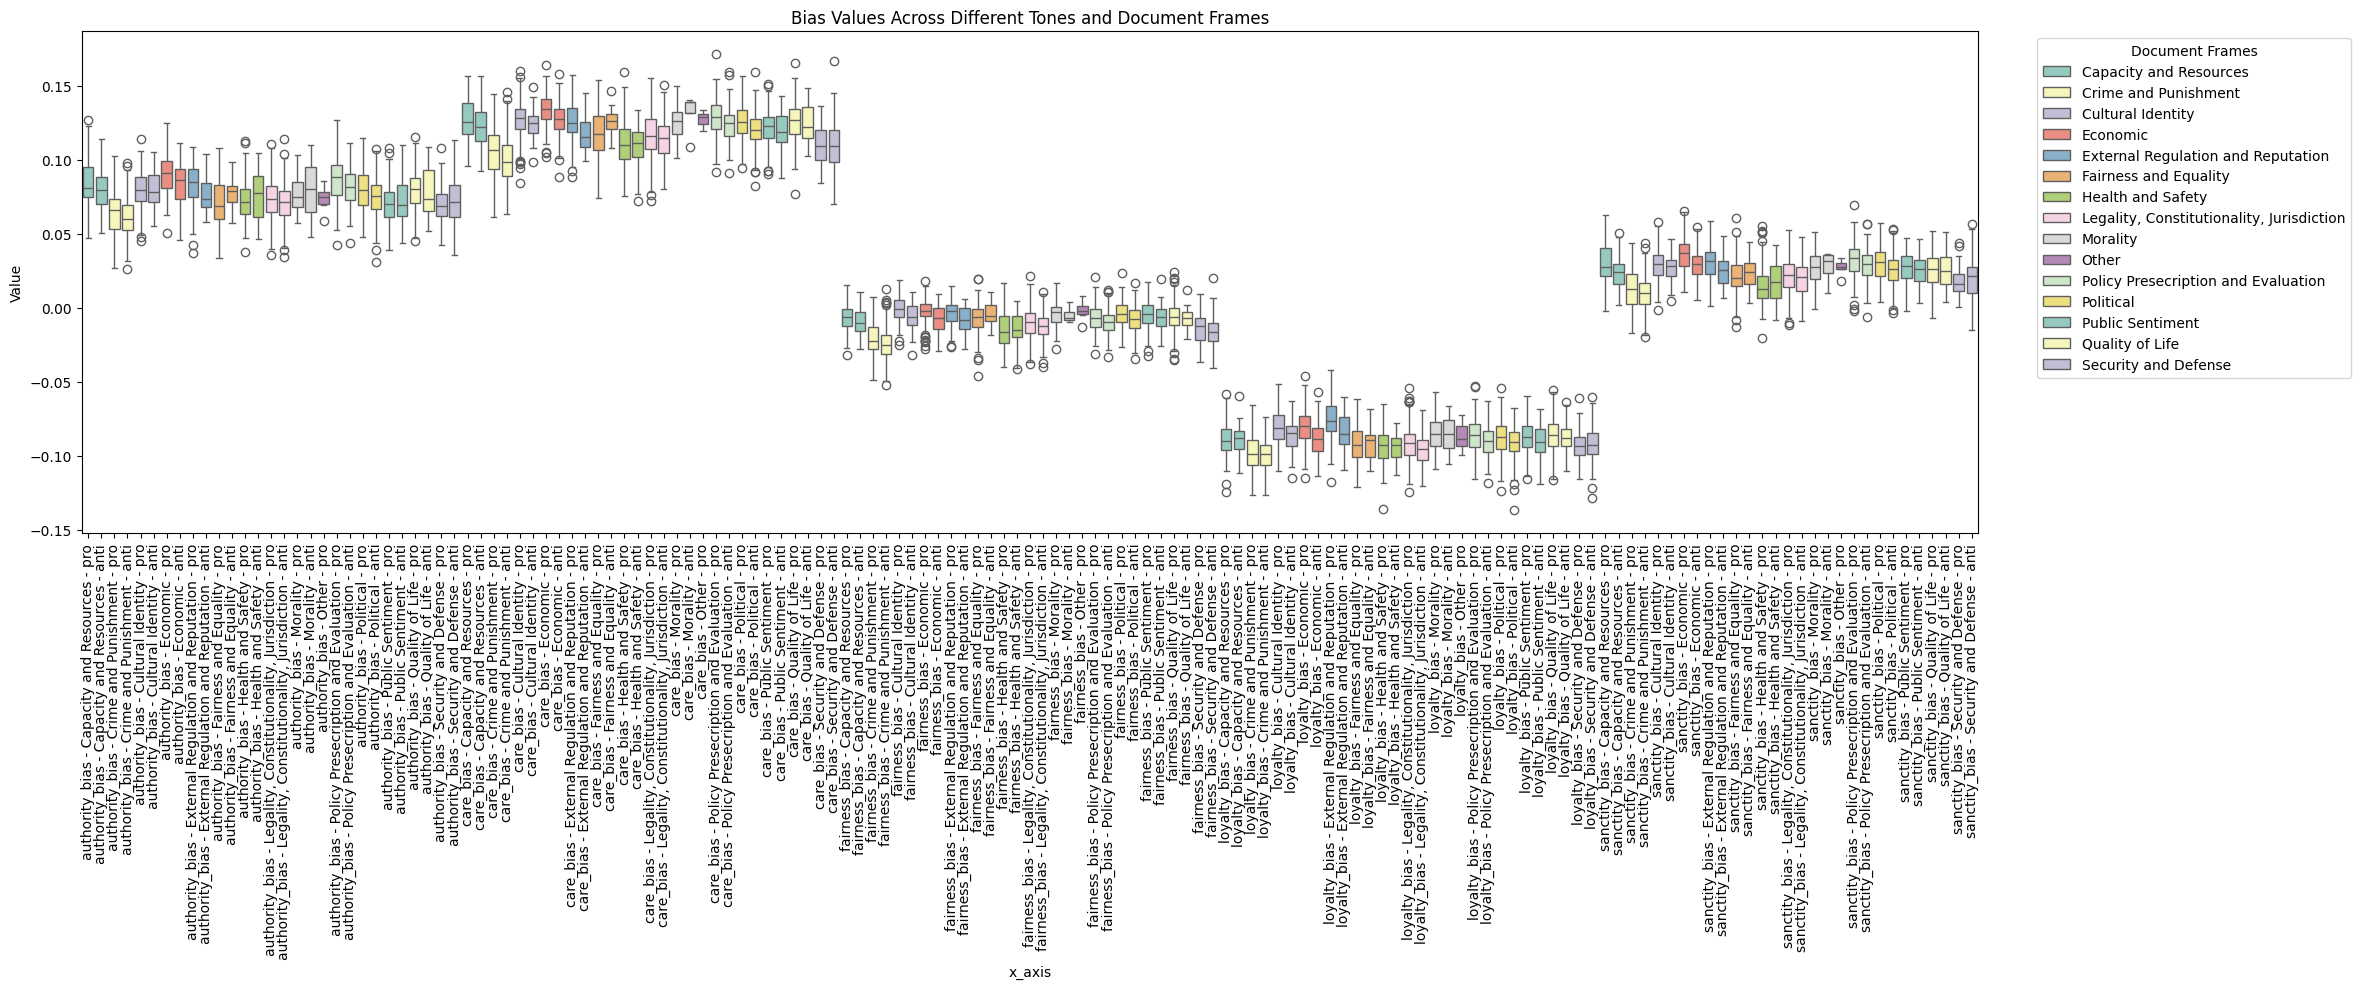

In [27]:
def plot_bias_foundations(df, foundations, tones=['pro', 'neutral', 'anti']):

    # Filtering the DataFrame for the tones we are interested in
    df = df[df['tone'].isin(tones)]

    # Melting the DataFrame for the bias values we are interested in
    bias_columns = foundations
    melted_bias = df.melt(id_vars=[ 'document_frame', 'tone'], value_vars=bias_columns, 
                          var_name='Metric', value_name='Value')

    # Drop NaN values
    melted_bias.dropna(inplace=True)

    # Creating a composite key for plotting, which combines the 'Metric', 'document_frame', and 'tone'
    melted_bias['x_axis'] = melted_bias.apply(
        lambda x: f"{x['Metric']} - {x['document_frame']} - {x['tone']}", axis=1
    )

    # Sort the melted DataFrame to define the order of boxplots
    melted_bias.sort_values(by=['Metric', 'document_frame', 'tone'], inplace=True)

    # The order of x-ticks is defined by the sorted unique values of 'x_axis'
    x_ticks_order = melted_bias['x_axis'].unique()

    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Create a boxplot and map colors to 'document_frame'
    boxplot = sns.boxplot(x='x_axis', y='Value', data=melted_bias, hue='document_frame', palette='Set3', order=x_ticks_order, dodge=False)

    plt.title('Bias Values Across Different Tones and Document Frames')
    plt.xticks(rotation=90)  # Rotating the x-ticks to prevent overlap due to the long names
    plt.tight_layout()
    
    # Adding legend
    handles, labels = boxplot.get_legend_handles_labels()
    plt.legend(handles, labels, bbox_to_anchor=(1.20, 1), title="Document Frames", loc='upper right')
    
    plt.show()


# 'authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'
plot_bias_foundations(df,  ['authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'], tones=['pro', 'anti'])

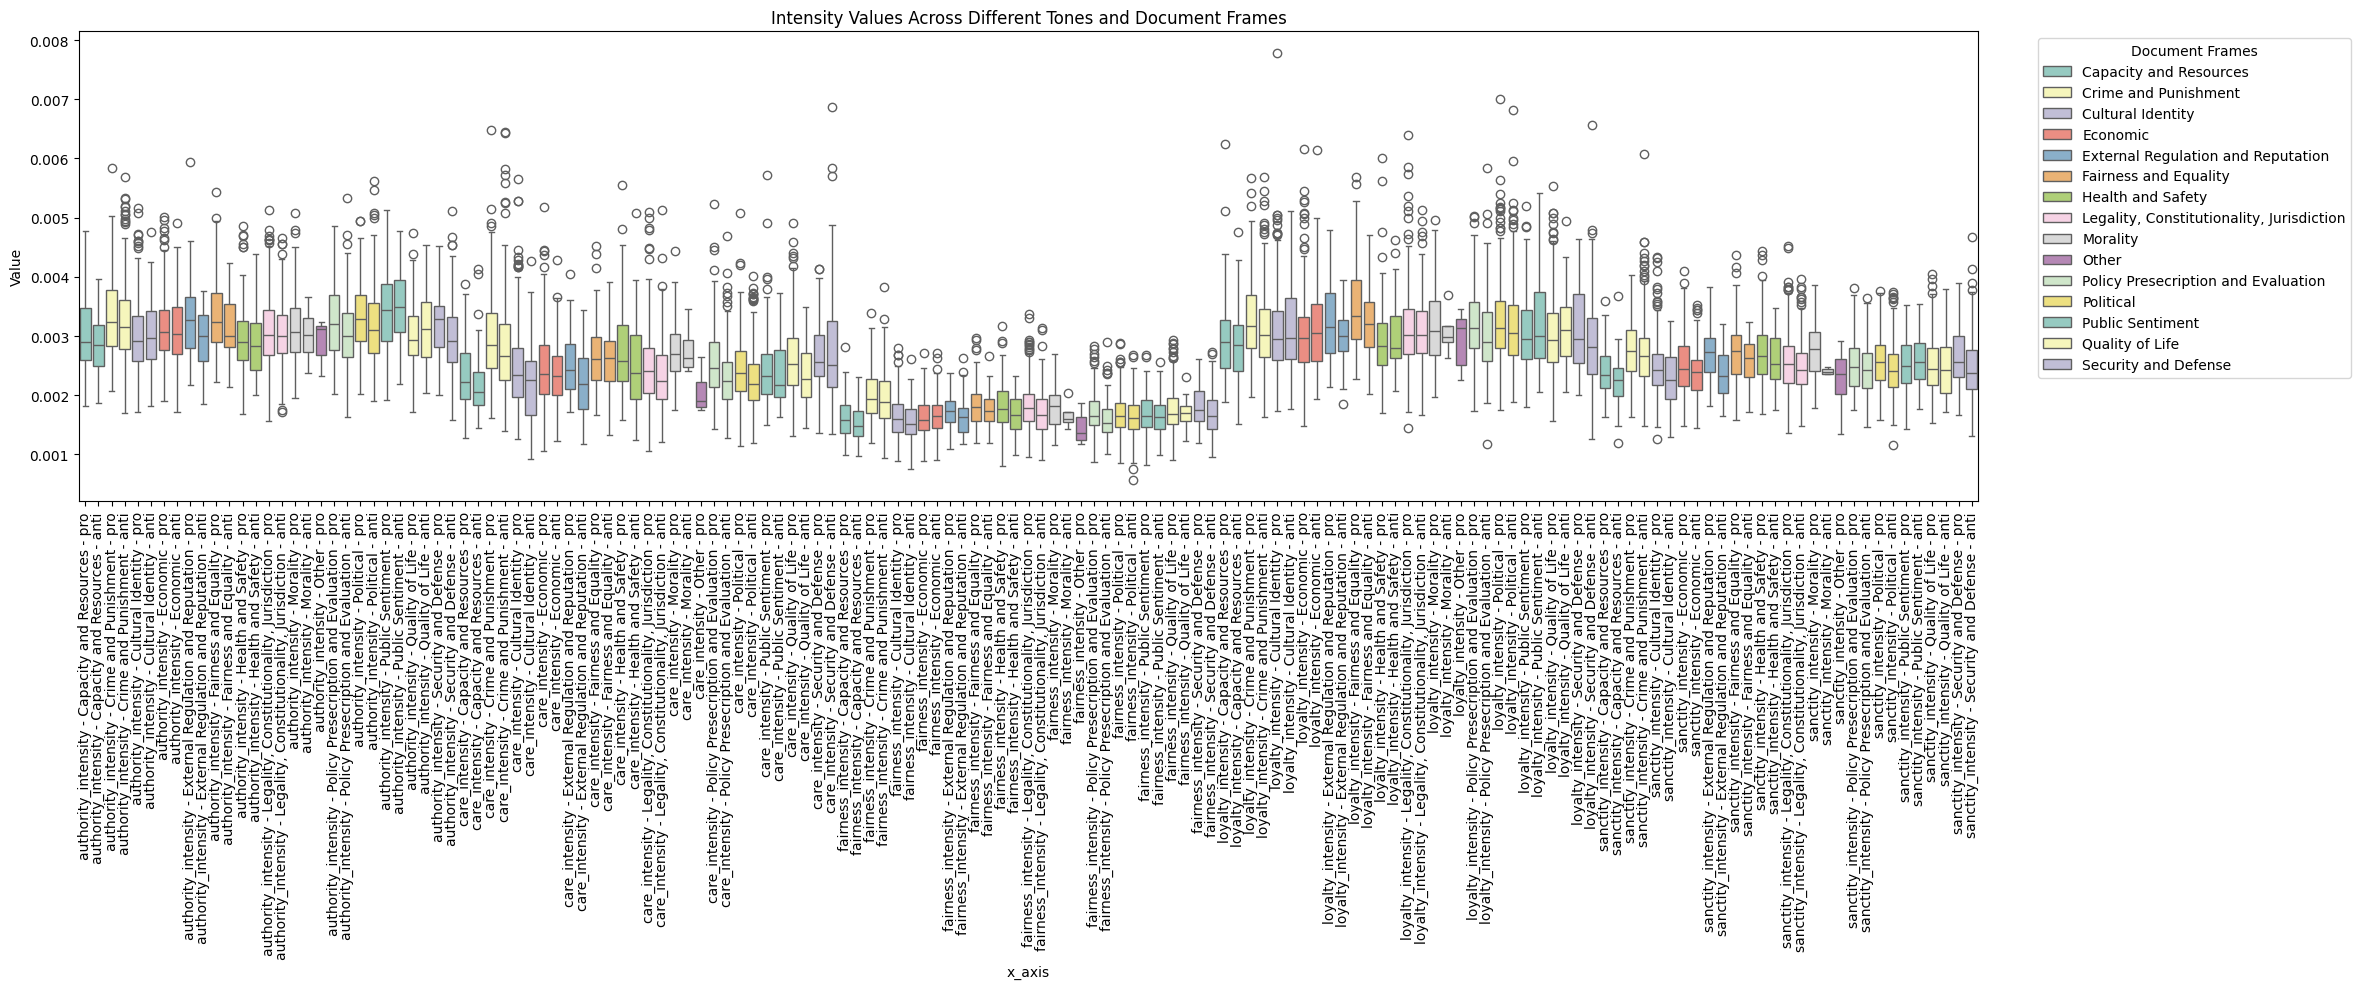

In [28]:
def plot_intensity_foundations(df, foundations, tones=['pro', 'neutral', 'anti']):
    # Filtering the DataFrame for the tones we are interested in
    df = df[df['tone'].isin(tones)]

    # Melting the DataFrame for the bias values we are interested in
    bias_columns = foundations
    melted_bias = df.melt(id_vars=['article_id', 'document_frame', 'tone', 'text'], value_vars=bias_columns, 
                          var_name='Metric', value_name='Value')

    # Drop NaN values
    melted_bias.dropna(inplace=True)

    # Creating a composite key for plotting, which combines the 'Metric', 'document_frame', and 'tone'
    melted_bias['x_axis'] = melted_bias.apply(
        lambda x: f"{x['Metric']} - {x['document_frame']} - {x['tone']}", axis=1
    )

    # Sort the melted DataFrame to define the order of boxplots
    melted_bias.sort_values(by=['Metric', 'document_frame', 'tone'], inplace=True)

    # The order of x-ticks is defined by the sorted unique values of 'x_axis'
    x_ticks_order = melted_bias['x_axis'].unique()

    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Create a boxplot and map colors to 'document_frame'
    boxplot = sns.boxplot(x='x_axis', y='Value', data=melted_bias, hue='document_frame', palette='Set3', order=x_ticks_order, dodge=False)

    plt.title('Intensity Values Across Different Tones and Document Frames')
    plt.xticks(rotation=90)  # Rotating the x-ticks to prevent overlap due to the long names
    plt.tight_layout()
    
    # Adding legend
    handles, labels = boxplot.get_legend_handles_labels()
    plt.legend(handles, labels, bbox_to_anchor=(1.20, 1), title="Document Frames", loc='upper right')
    
    plt.show()


# 'authority_intensity', 'care_intensity', 'fairness_intensity', 'loyalty_intensity', 'sanctity_intensity'
plot_intensity_foundations(df,  ['authority_intensity', 'care_intensity', 'fairness_intensity', 'loyalty_intensity', 'sanctity_intensity'], tones=['pro', 'anti'])

C:\Users\elias\AppData\Local\Temp\ipykernel_28132\1380406241.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='x_axis', y='Value', data=melted_bias, palette='Set3', order=x_ticks_order)


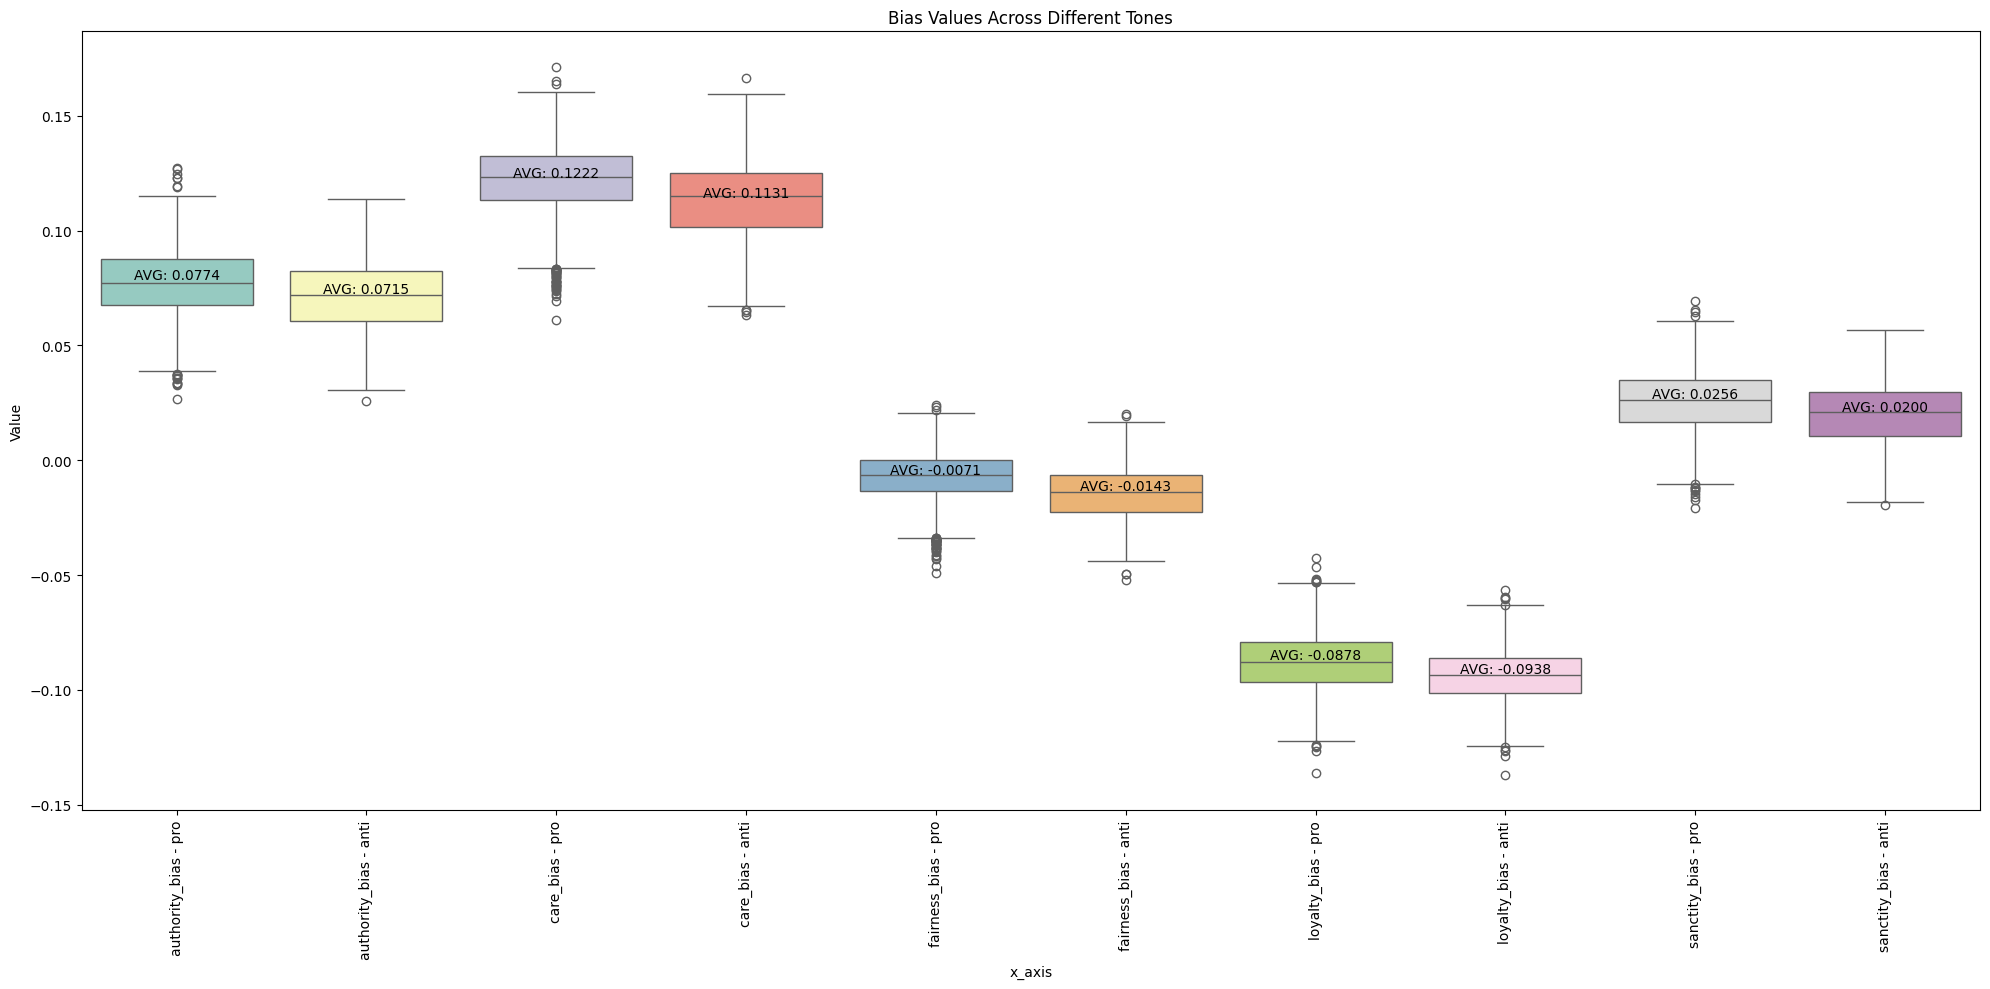

In [96]:
def plot_bias_foundations(df, foundations, tones=['pro', 'neutral', 'anti']):
    # Filtering the DataFrame for the tones we are interested in
    df = df[df['tone'].isin(tones)]

    # Melting the DataFrame for the bias values we are interested in
    bias_columns = foundations
    melted_bias = df.melt(id_vars=['tone'], value_vars=bias_columns, 
                          var_name='Metric', value_name='Value')

    # Drop NaN values
    melted_bias.dropna(inplace=True)

    # Creating a composite key for plotting, which combines the 'Metric' and 'tone'
    melted_bias['x_axis'] = melted_bias.apply(
        lambda x: f"{x['Metric']} - {x['tone']}", axis=1
    )

    # Sort the melted DataFrame to define the order of boxplots
    melted_bias.sort_values(by=['Metric', 'tone'], inplace=True)

    # The order of x-ticks is defined by the sorted unique values of 'x_axis'
    x_ticks_order = melted_bias['x_axis'].unique()

    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Create a boxplot
    sns.boxplot(x='x_axis', y='Value', data=melted_bias, palette='Set3', order=x_ticks_order)

    plt.title('Bias Values Across Different Tones')
    plt.xticks(rotation=90)  # Rotating the x-ticks to prevent overlap due to the long names

    # Calculating and annotating the mean for each group in the boxplot
    for i, group in enumerate(x_ticks_order):
        # Getting the mean of the values in the current group
        group_data = melted_bias[melted_bias['x_axis'] == group]['Value']
        mean_val = group_data.mean()
        
        # Annotating the mean
        plt.text(i, mean_val, f'AVG: {mean_val:.4f}', color='black', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


# 'authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'
plot_bias_foundations(df, ['authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'], tones=['pro', 'anti'])

C:\Users\elias\AppData\Local\Temp\ipykernel_28132\404093785.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='x_axis', y='Value', data=melted_intensity, palette='Set3', order=x_ticks_order)


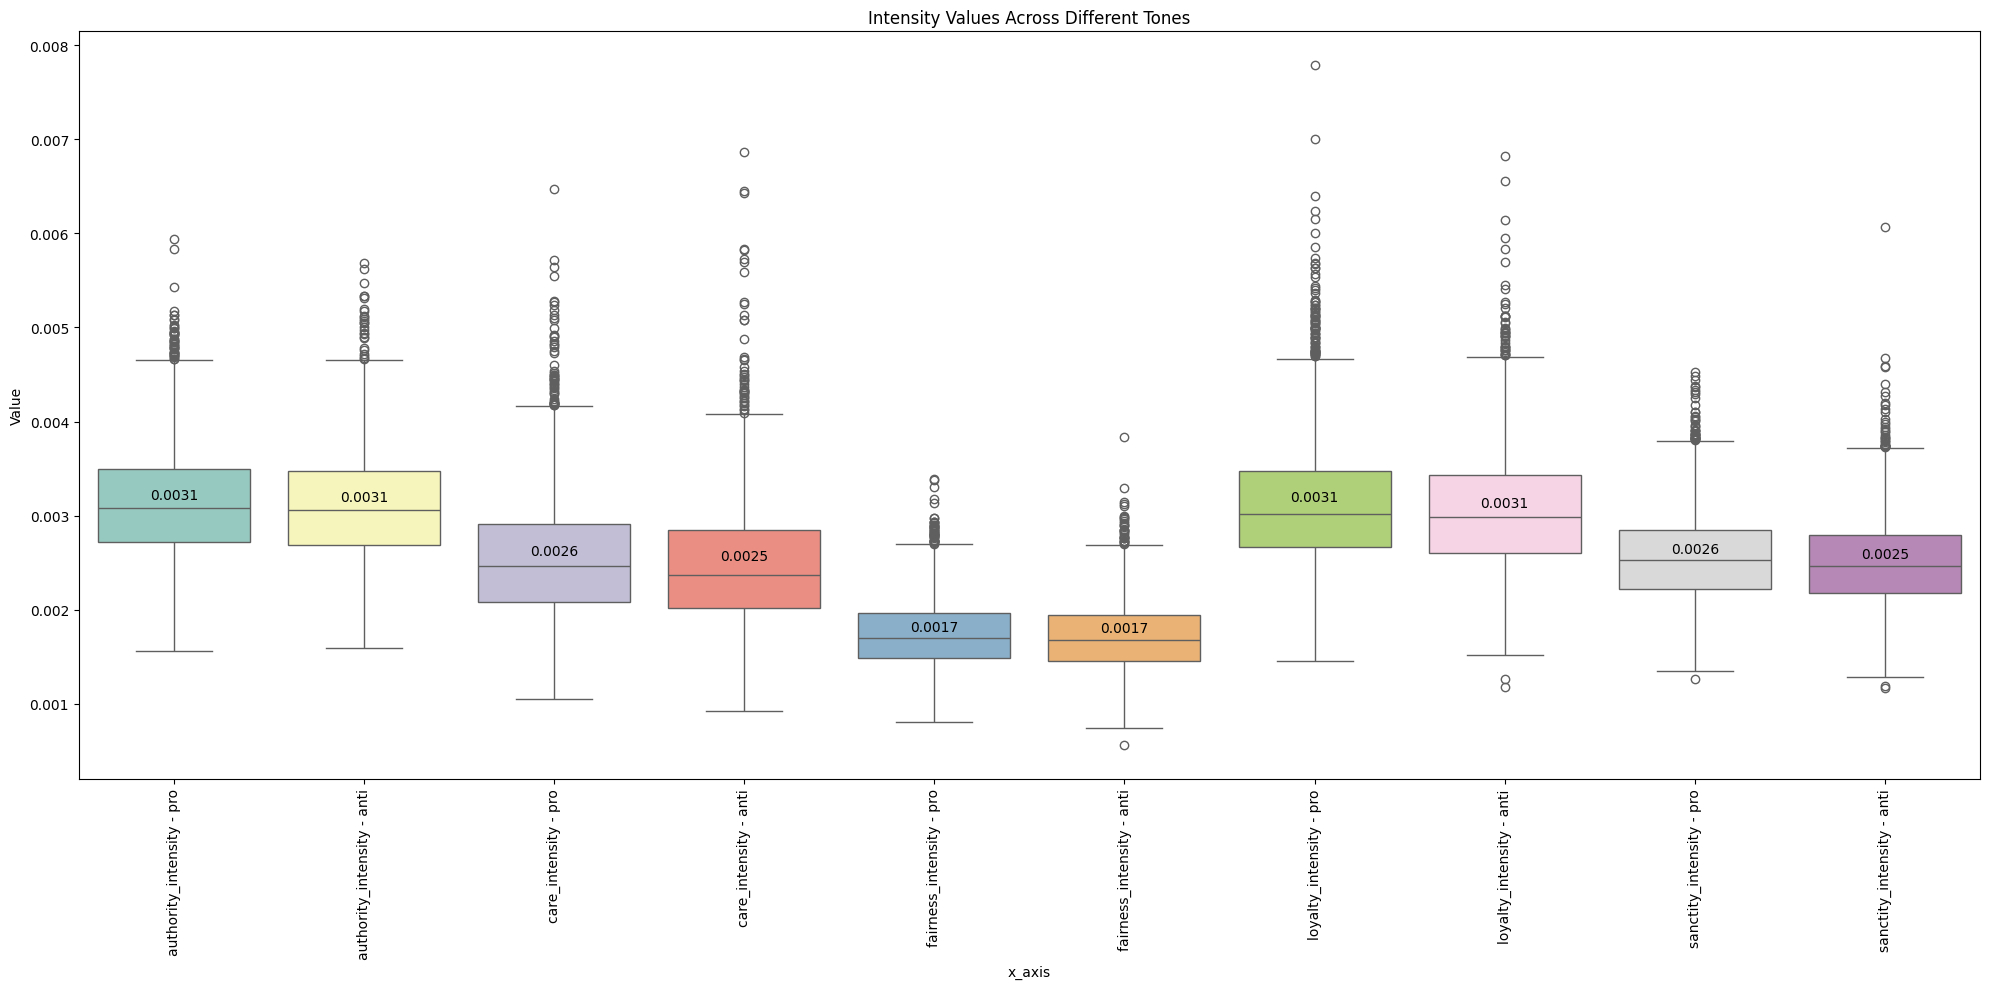

In [30]:
def plot_intensity_foundations(df, foundations, tones=['pro', 'neutral', 'anti']):
    # Filtering the DataFrame for the tones we are interested in
    df = df[df['tone'].isin(tones)]

    # Melting the DataFrame for the bias values we are interested in
    bias_columns = foundations
    melted_intensity = df.melt(id_vars=['tone'], value_vars=intensity_columns, 
                          var_name='Metric', value_name='Value')

    # Drop NaN values
    melted_intensity.dropna(inplace=True)

    # Creating a composite key for plotting, which combines the 'Metric' and 'tone'
    melted_intensity['x_axis'] = melted_intensity.apply(
        lambda x: f"{x['Metric']} - {x['tone']}", axis=1
    )

    # Sort the melted DataFrame to define the order of boxplots
    melted_intensity.sort_values(by=['Metric', 'tone'], inplace=True)

    # The order of x-ticks is defined by the sorted unique values of 'x_axis'
    x_ticks_order = melted_intensity['x_axis'].unique()

    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Create a boxplot
    sns.boxplot(x='x_axis', y='Value', data=melted_intensity, palette='Set3', order=x_ticks_order)

    plt.title('Intensity Values Across Different Tones')
    plt.xticks(rotation=90)  # Rotating the x-ticks to prevent overlap due to the long names

    # Calculating and annotating the mean for each group in the boxplot
    for i, group in enumerate(x_ticks_order):
        # Getting the mean of the values in the current group
        group_data = melted_intensity[melted_intensity['x_axis'] == group]['Value']
        mean_val = group_data.mean()
        
        # Annotating the mean
        plt.text(i, mean_val, f'{mean_val:.4f}', color='black', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


# 'authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'
plot_intensity_foundations(df, ['authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'], tones=['pro', 'anti'])

### Plot Bias and Intensity for each foundation WITHOUT tone

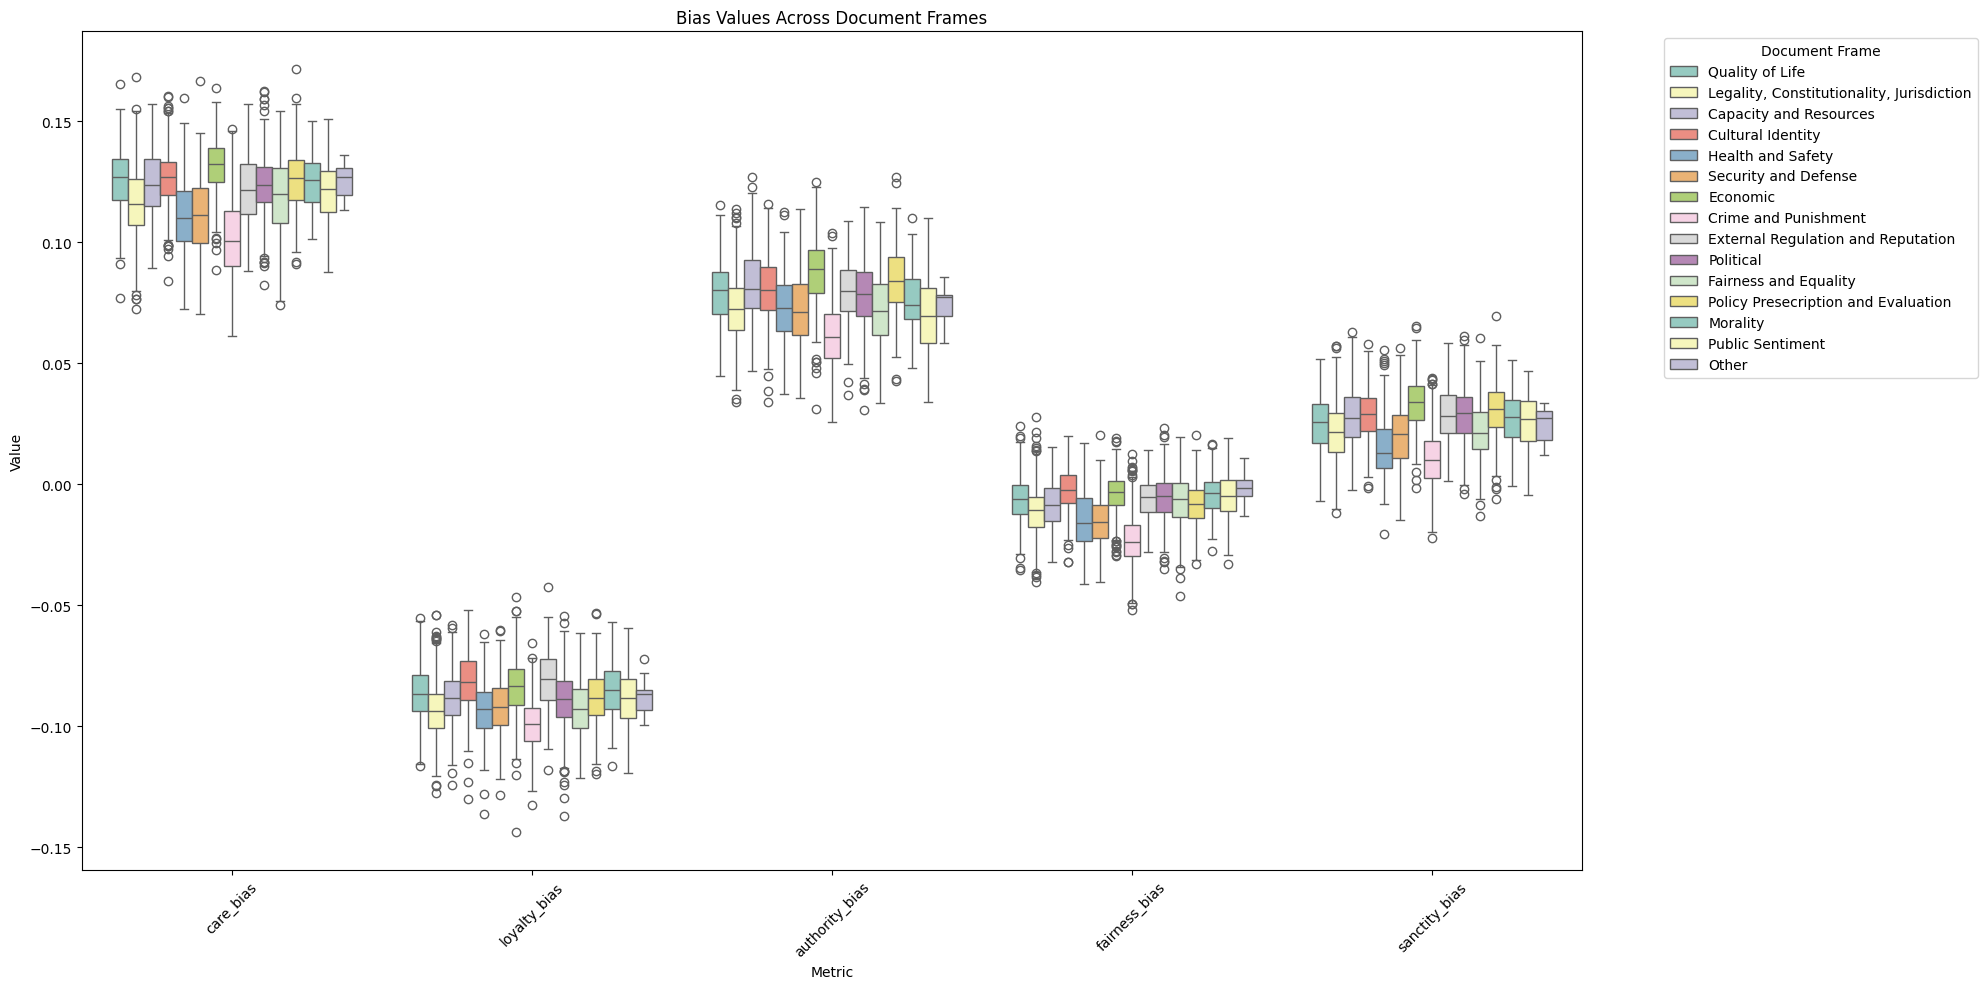

In [31]:
melted_bias = df.melt(id_vars=['document_frame'], value_vars=bias_columns, 
                                var_name='Metric', value_name='Value')
melted_bias['Type'] = 'Bias'

# Combining bias and intensity data
combined_data = pd.concat([melted_bias])

# Plotting
plt.figure(figsize=(20, 10))
sns.boxplot(x='Metric', y='Value', hue='document_frame', data=combined_data, palette='Set3')
plt.title('Bias Values Across Document Frames')
plt.xticks(rotation=45)
plt.legend(title='Document Frame', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

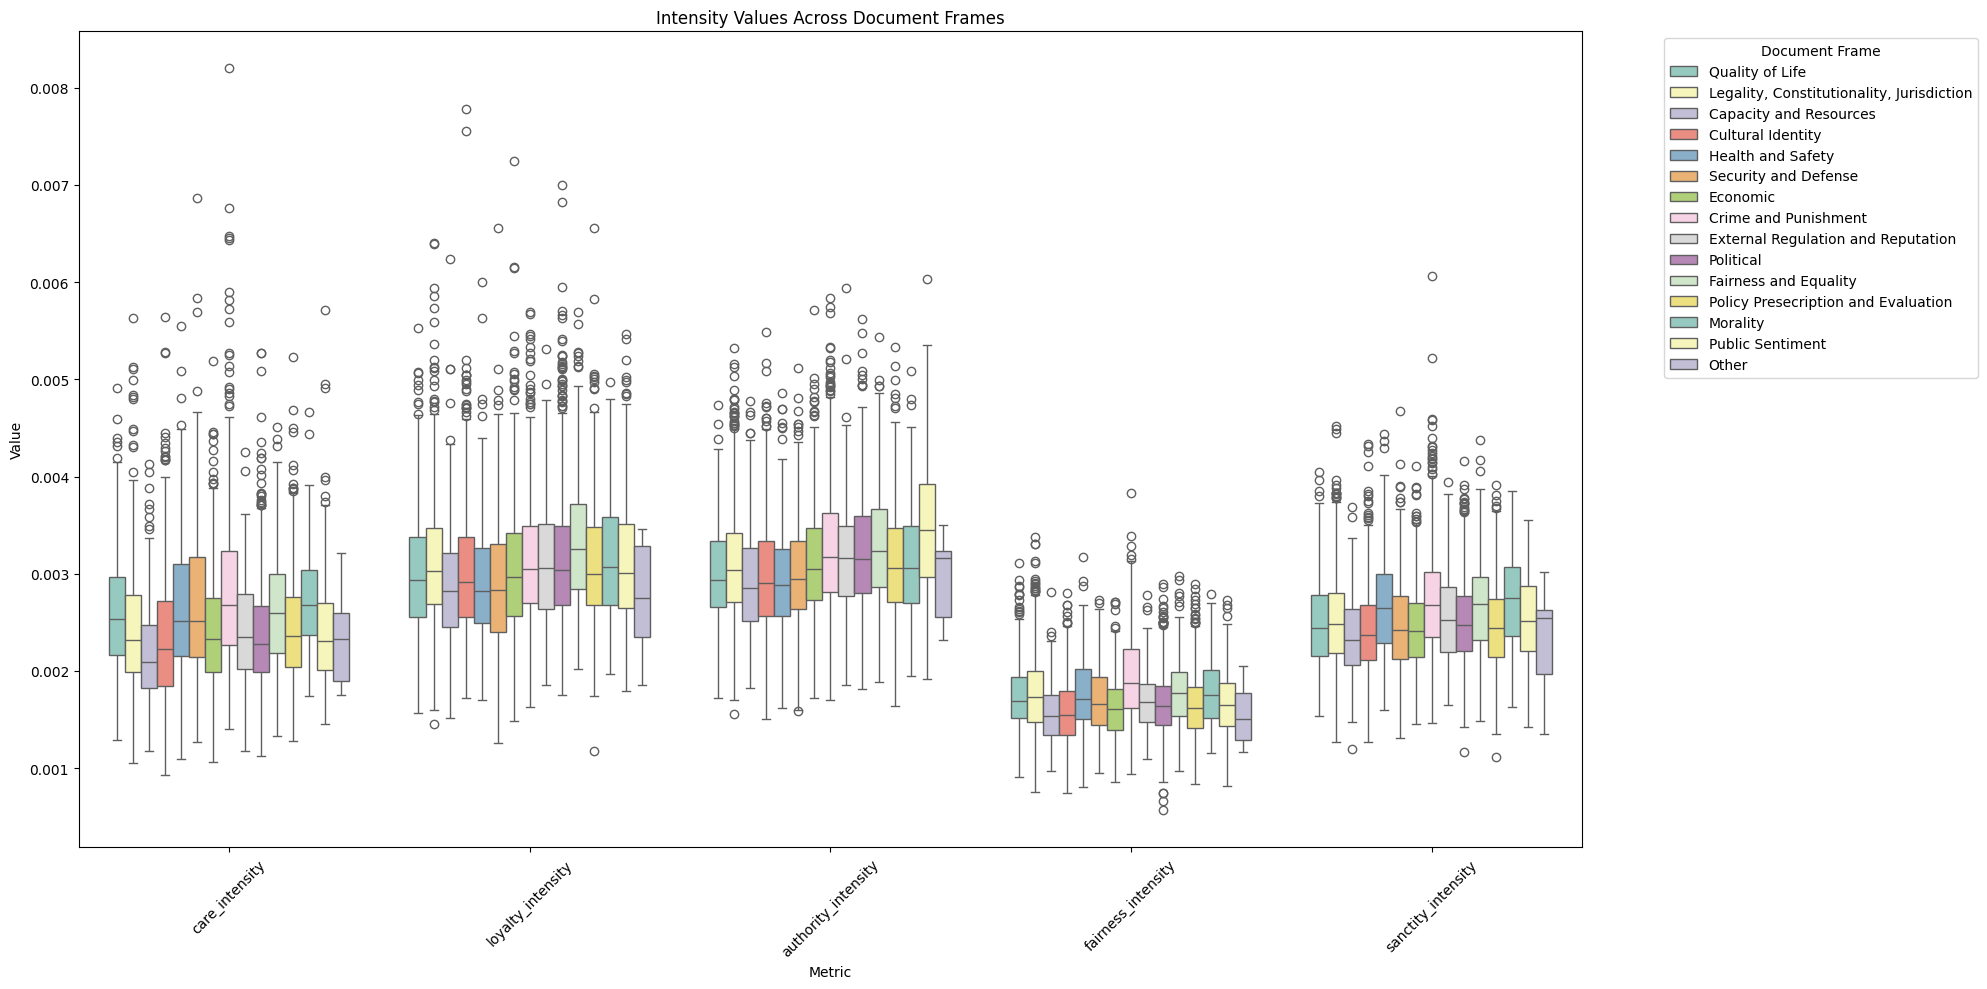

In [32]:
melted_intensity = df.melt(id_vars=['document_frame'], value_vars=intensity_columns, 
                                     var_name='Metric', value_name='Value')
melted_intensity['Type'] = 'Intensity'

# Combining bias and intensity data
combined_data = pd.concat([melted_intensity])

# Plotting
plt.figure(figsize=(20, 10))
sns.boxplot(x='Metric', y='Value', hue='document_frame', data=combined_data, palette='Set3')
plt.title('Intensity Values Across Document Frames')
plt.xticks(rotation=45)
plt.legend(title='Document Frame', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Plot Bias & Intensity for single foundation WITHOUT tone

C:\Users\elias\AppData\Local\Temp\ipykernel_28132\2048301467.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_bias', data=df, palette='Set2')


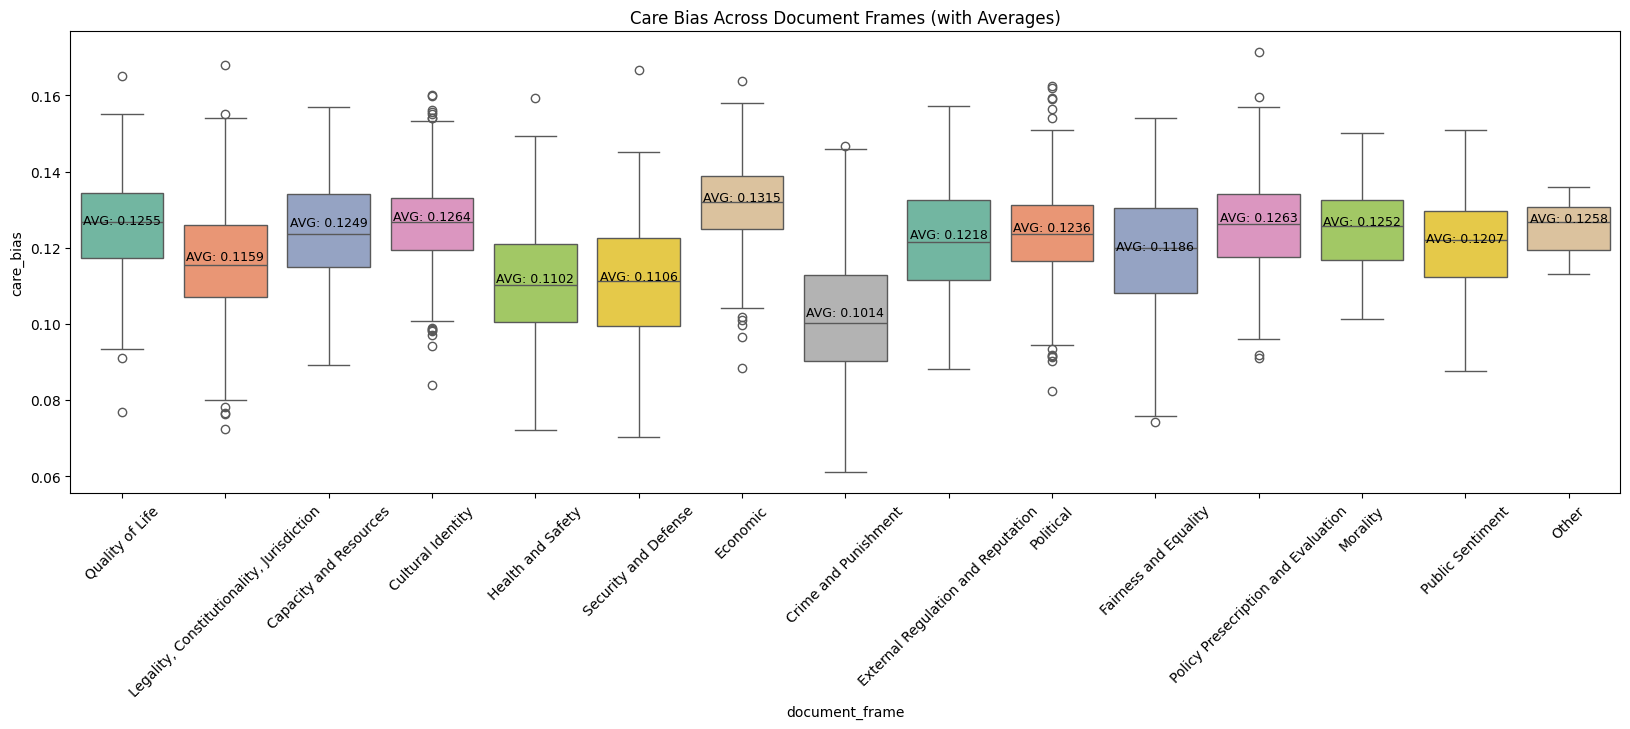

C:\Users\elias\AppData\Local\Temp\ipykernel_28132\2048301467.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_bias', data=df, palette='Set2')


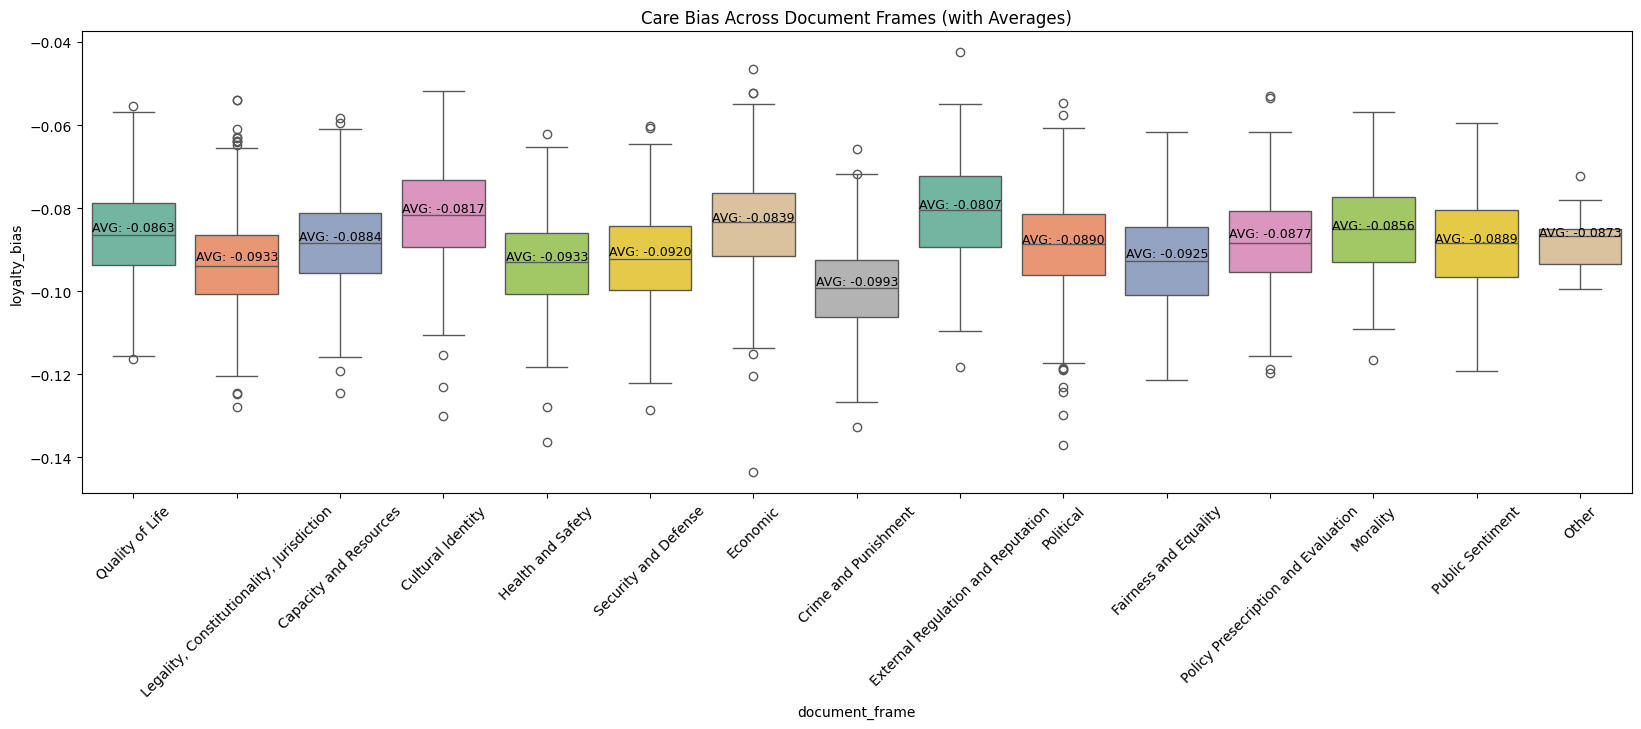

C:\Users\elias\AppData\Local\Temp\ipykernel_28132\2048301467.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_bias', data=df, palette='Set2')


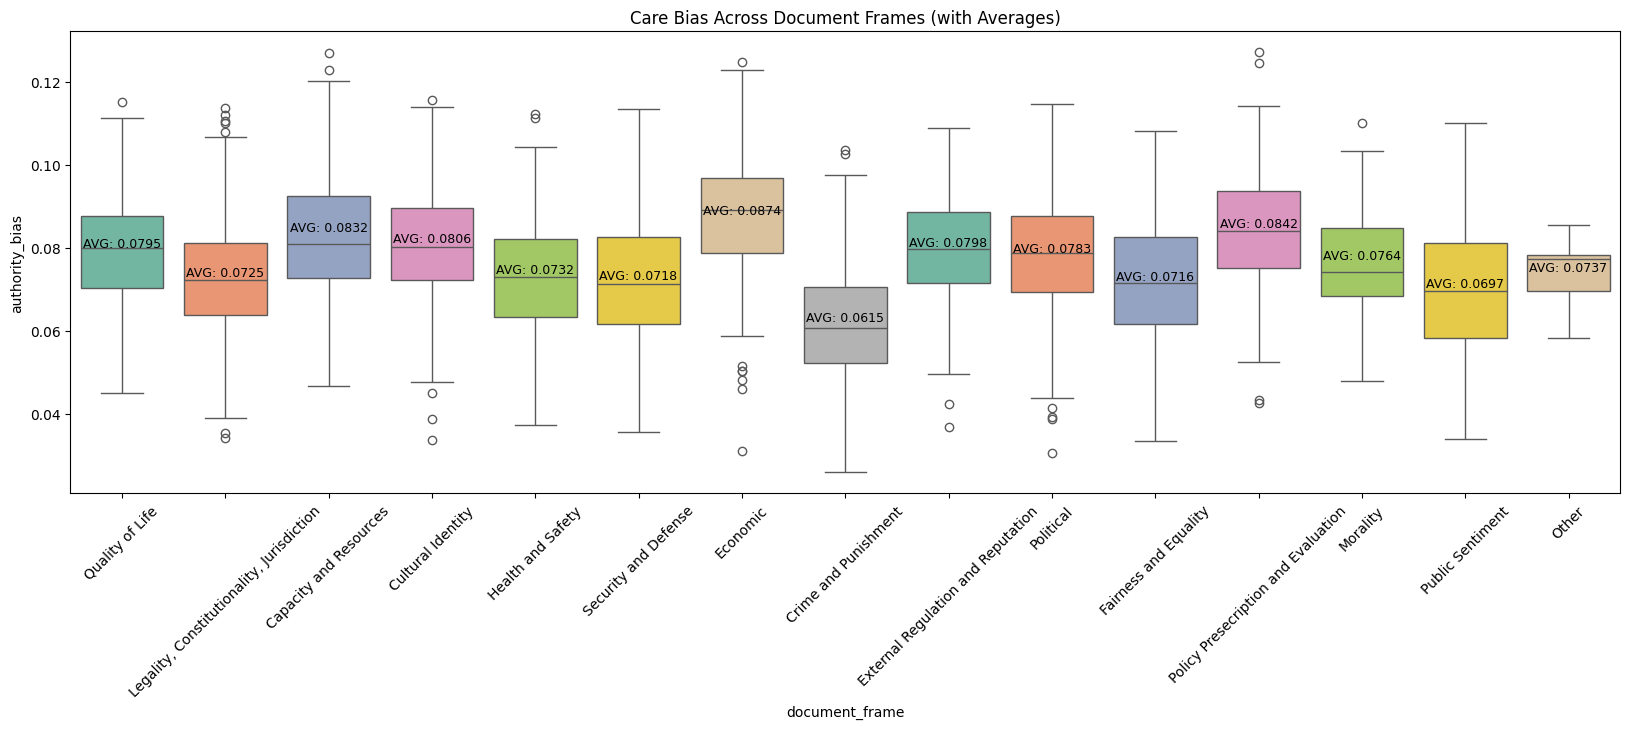

C:\Users\elias\AppData\Local\Temp\ipykernel_28132\2048301467.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_bias', data=df, palette='Set2')


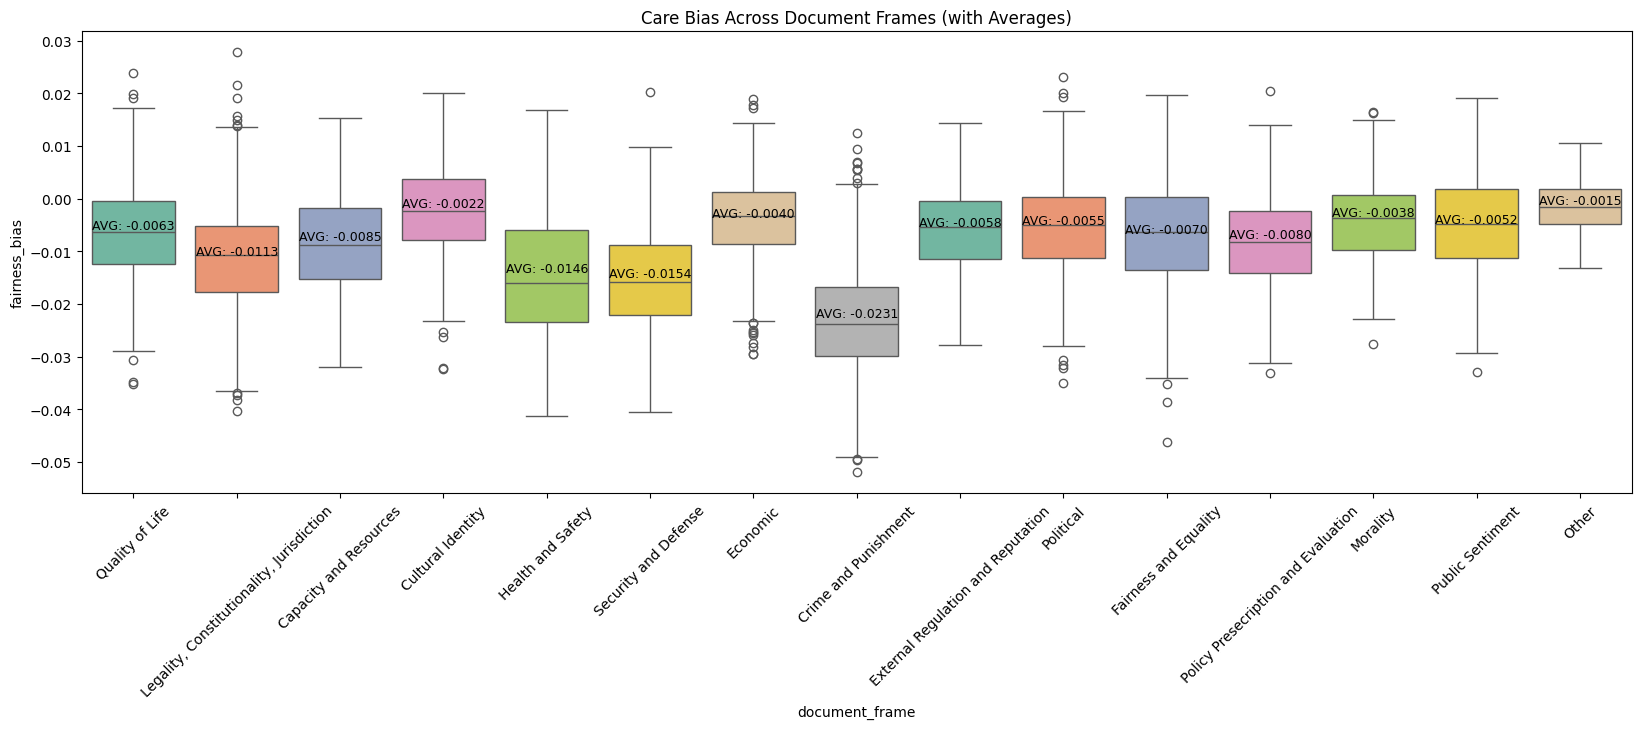

C:\Users\elias\AppData\Local\Temp\ipykernel_28132\2048301467.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_bias', data=df, palette='Set2')


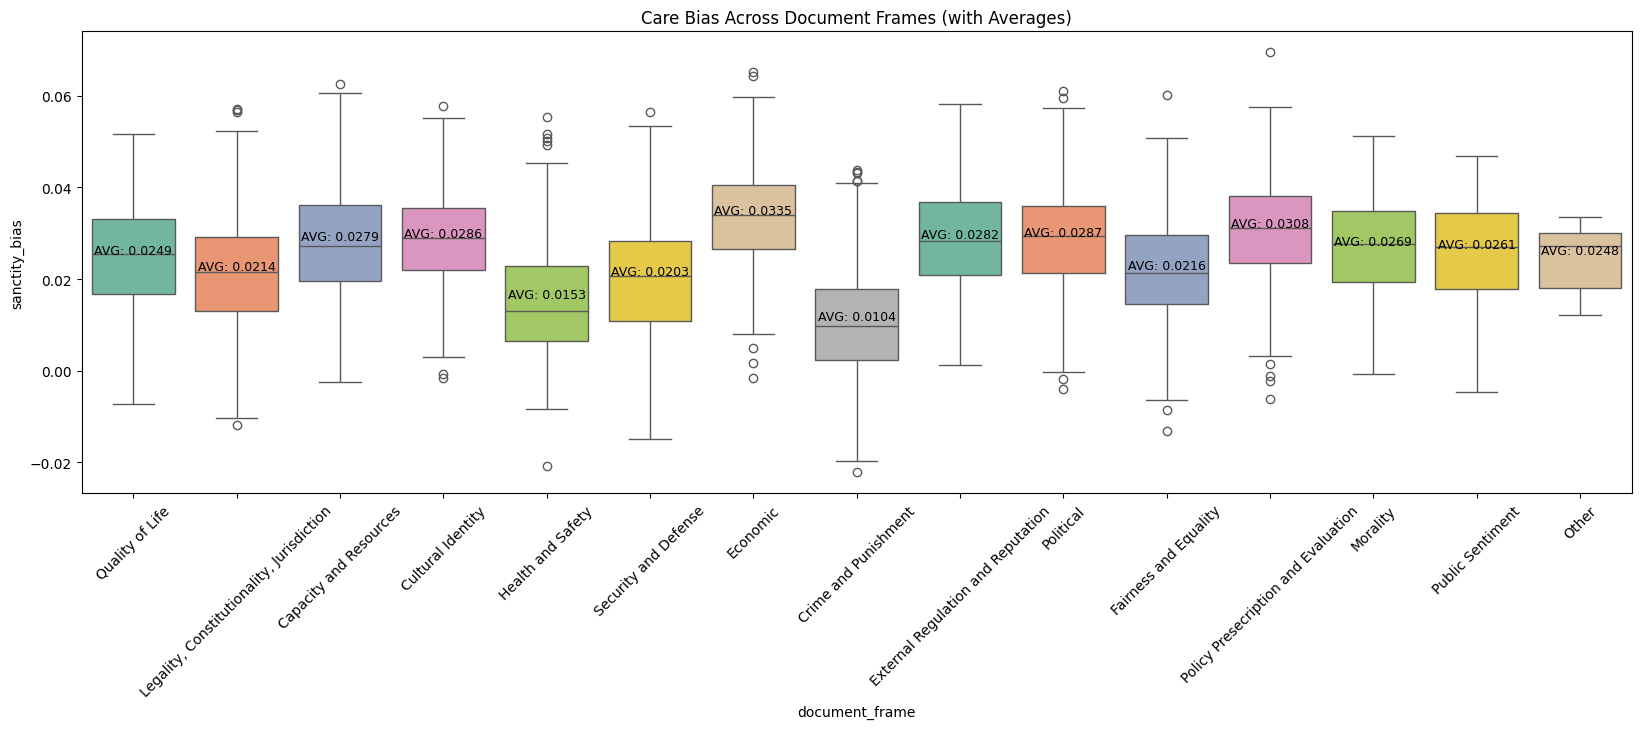

In [97]:
def plot_bias_per_foundation(foundation):
    means = df.groupby('document_frame')[foundation + '_bias'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(20, 6))
    ax = sns.boxplot(x='document_frame', y=foundation + '_bias', data=df, palette='Set2')
    plt.title('Care Bias Across Document Frames (with Averages)')

    # Annotating each box with the mean value
    for i, frame in enumerate(ax.get_xticklabels()):
        frame = frame.get_text()
        mean_val = means.loc[means['document_frame'] == frame, foundation + '_bias'].values[0]
        plt.text(i, mean_val, f'AVG: {mean_val:.4f}', fontsize=9, ha='center', va='bottom', color='black')

    plt.xticks(rotation=45)
    plt.show()

plot_bias_per_foundation('care')
plot_bias_per_foundation('loyalty')
plot_bias_per_foundation('authority')
plot_bias_per_foundation('fairness')
plot_bias_per_foundation('sanctity')

C:\Users\elias\AppData\Local\Temp\ipykernel_28132\3243909240.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_intensity', data=df, palette='Set2')


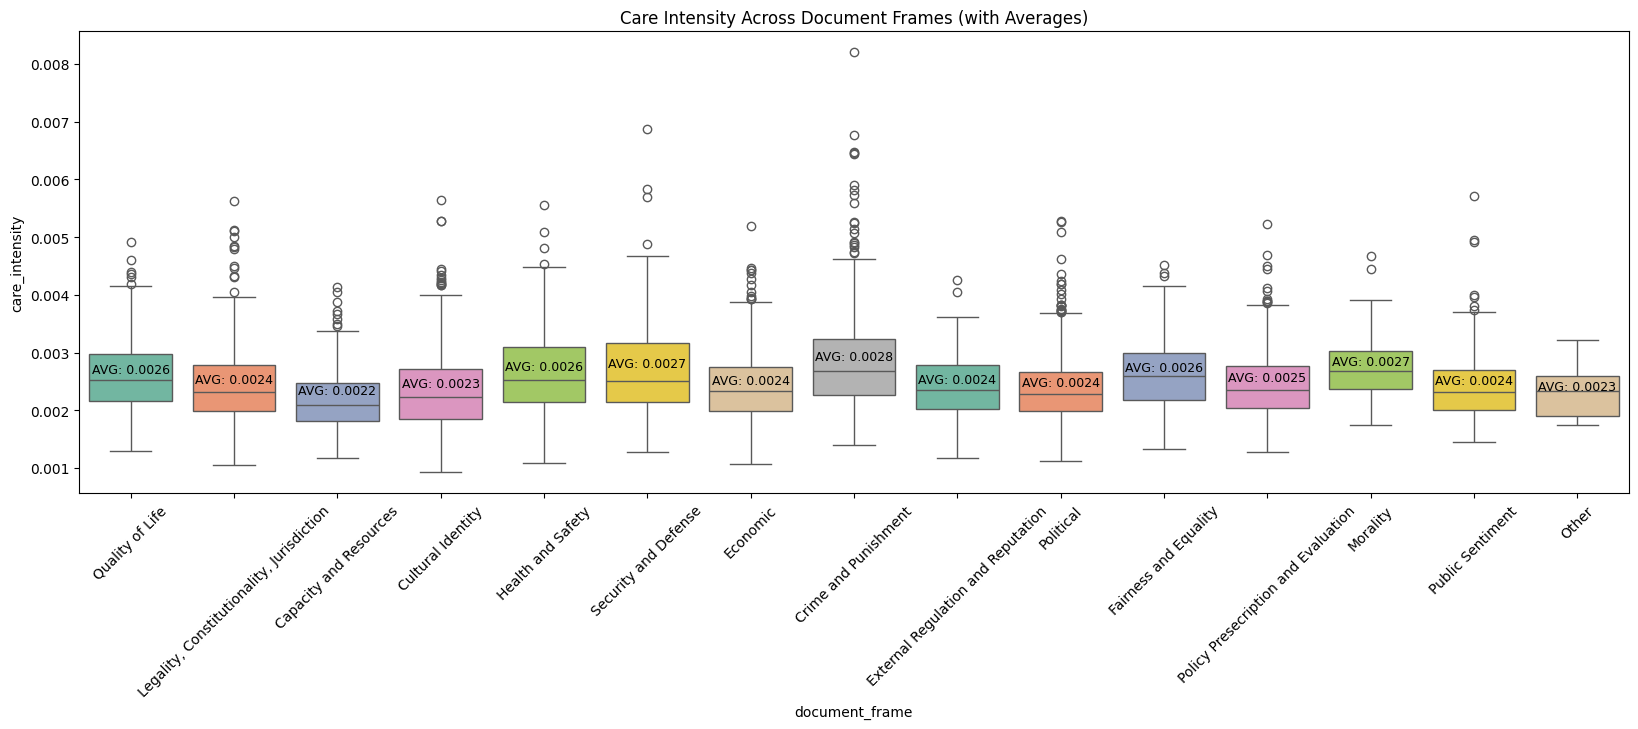

C:\Users\elias\AppData\Local\Temp\ipykernel_28132\3243909240.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_intensity', data=df, palette='Set2')


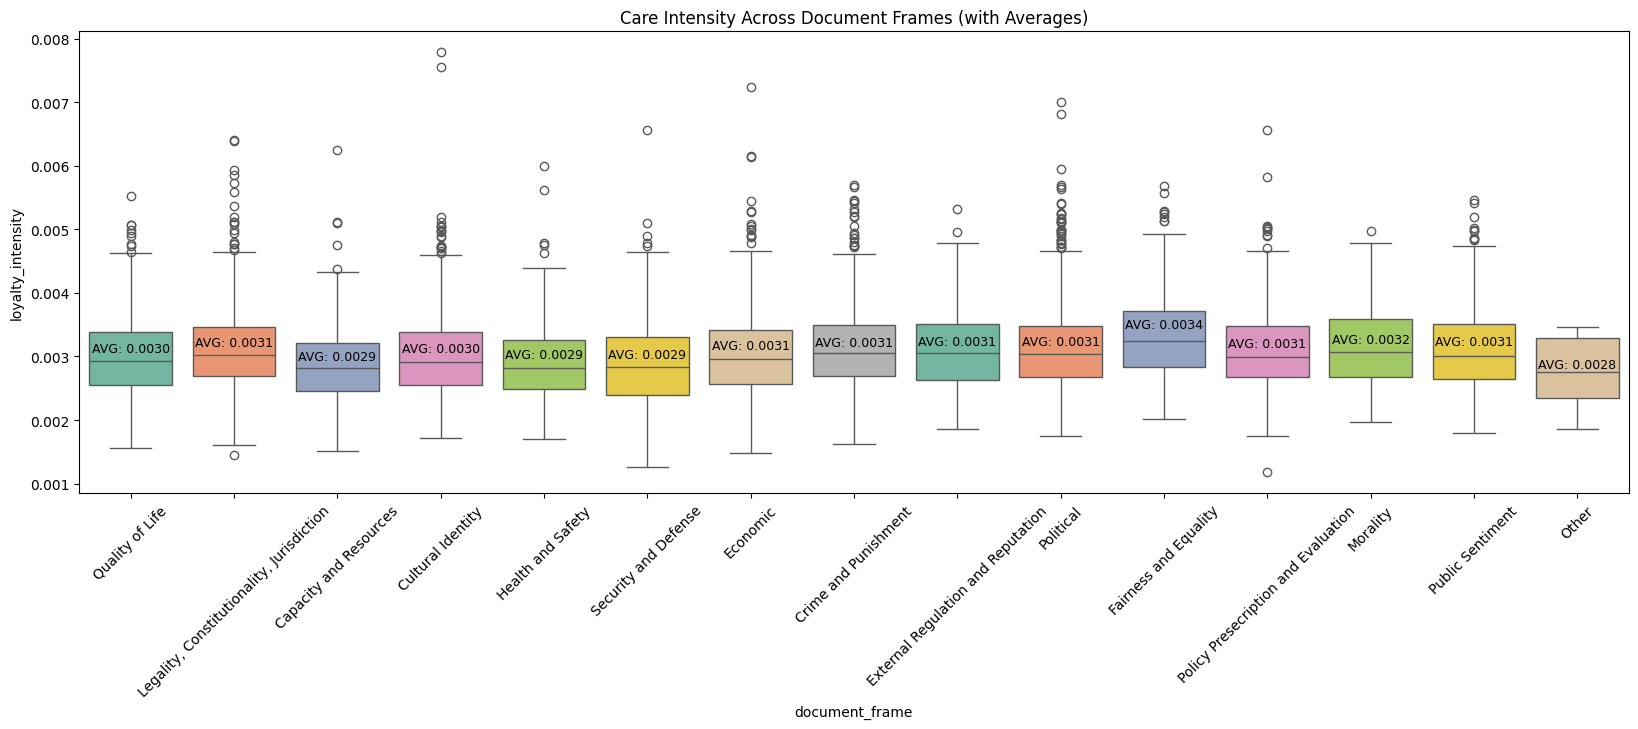

C:\Users\elias\AppData\Local\Temp\ipykernel_28132\3243909240.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_intensity', data=df, palette='Set2')


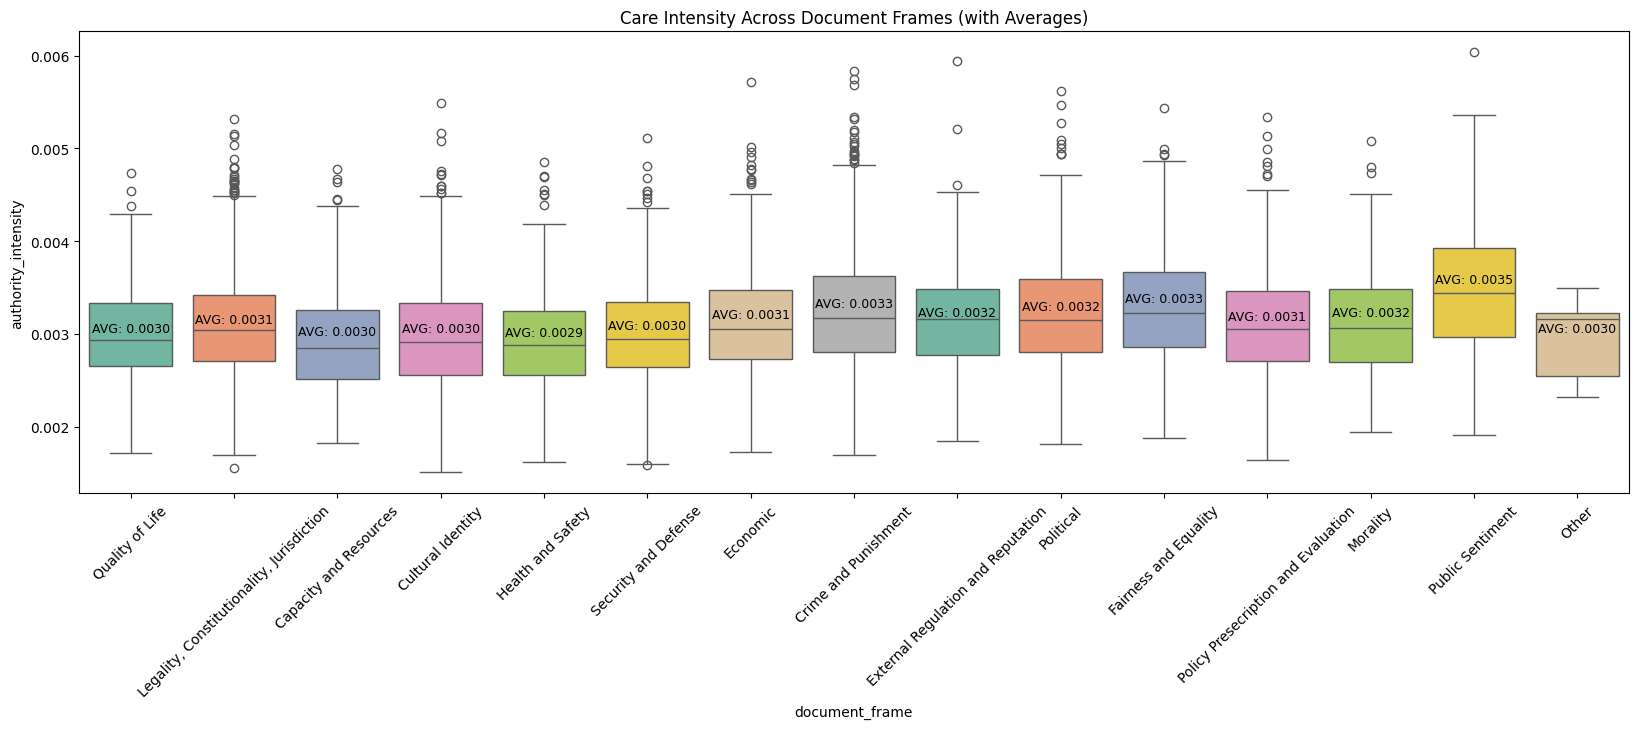

C:\Users\elias\AppData\Local\Temp\ipykernel_28132\3243909240.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_intensity', data=df, palette='Set2')


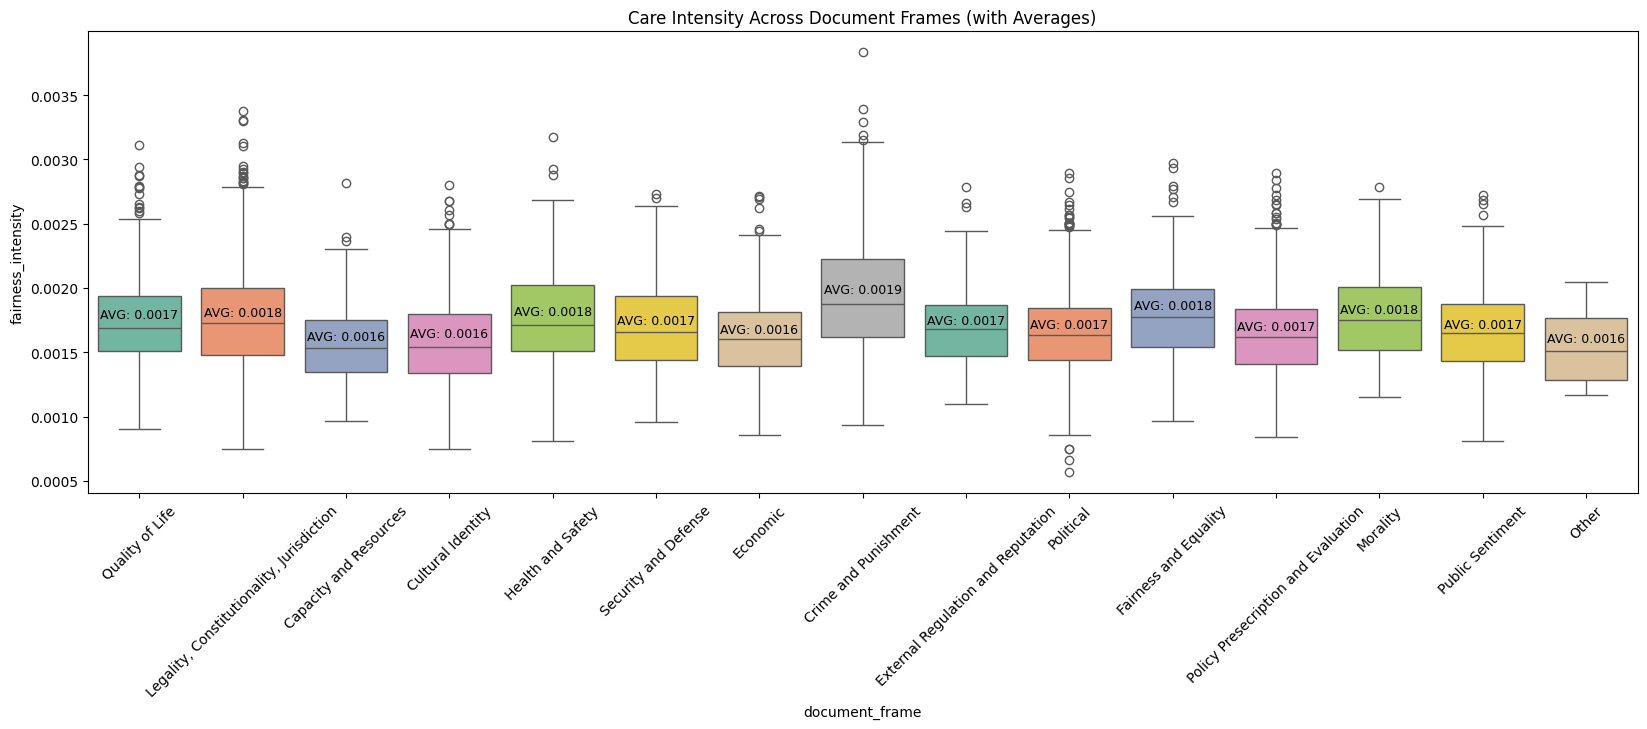

C:\Users\elias\AppData\Local\Temp\ipykernel_28132\3243909240.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='document_frame', y=foundation + '_intensity', data=df, palette='Set2')


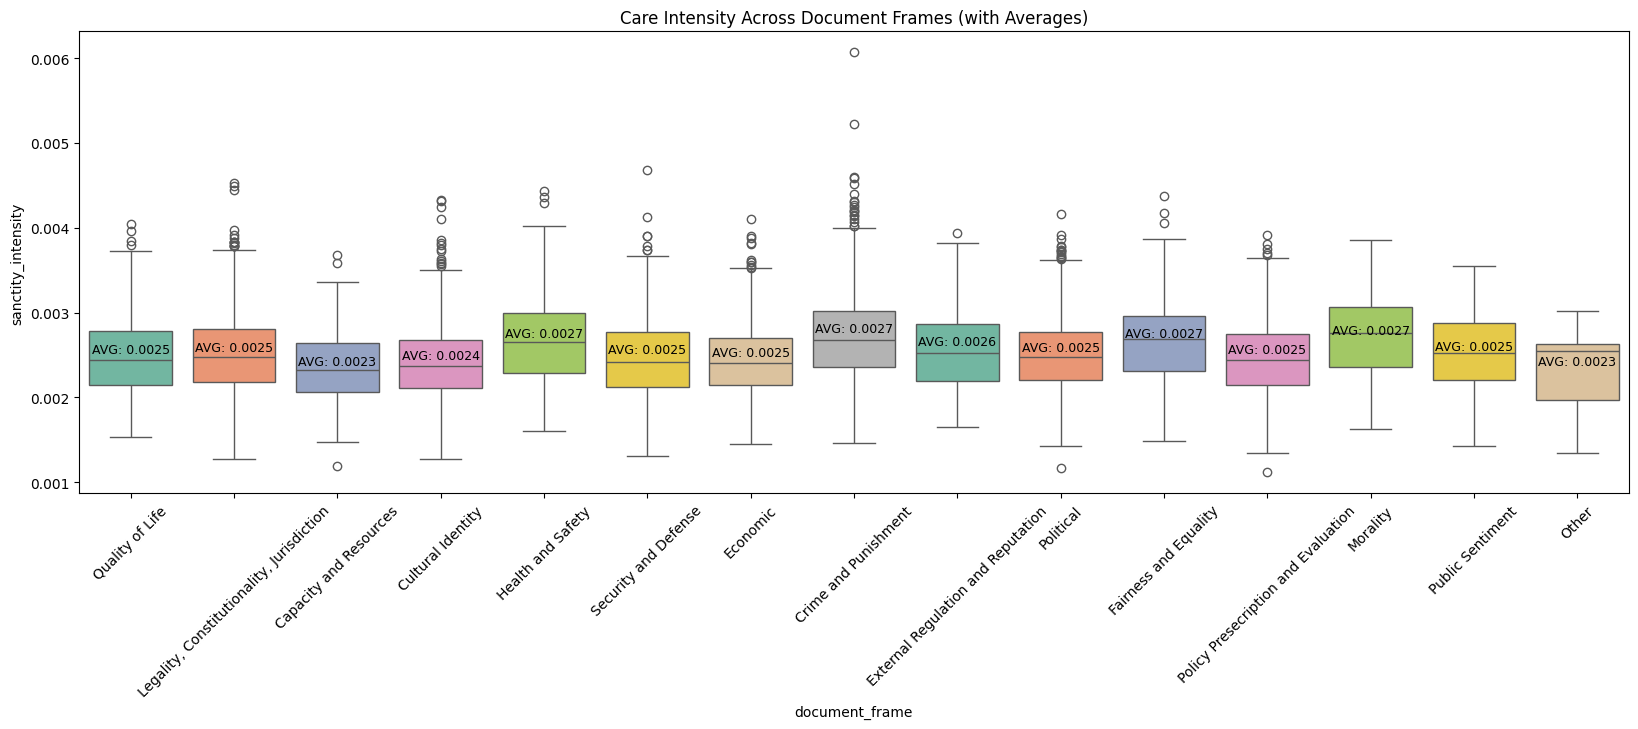

In [98]:
def plot_intensity_per_foundation(foundation):
    means = df.groupby('document_frame')[foundation + '_intensity'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(20, 6))
    ax = sns.boxplot(x='document_frame', y=foundation + '_intensity', data=df, palette='Set2')
    plt.title('Care Intensity Across Document Frames (with Averages)')

    # Annotating each box with the mean value
    for i, frame in enumerate(ax.get_xticklabels()):
        frame = frame.get_text()
        mean_val = means.loc[means['document_frame'] == frame, foundation + '_intensity'].values[0]
        plt.text(i, mean_val, f'AVG: {mean_val:.4f}', fontsize=9, ha='center', va='bottom', color='black')

    plt.xticks(rotation=45)
    plt.show()

plot_intensity_per_foundation('care')
plot_intensity_per_foundation('loyalty')
plot_intensity_per_foundation('authority')
plot_intensity_per_foundation('fairness')
plot_intensity_per_foundation('sanctity')

### Plot Bias as X and Intensity as Y axis

In [35]:
# find text which includes: "BILL ON IMMIGRANT WORKERS"
df_merged[df_merged['text'].str.contains("BILL ON IMMIGRANT WORKERS")]

article_id  authority_bias  authority_intensity  care_bias  \
54588  Immigration1.0-5807         0.02946             0.004142   0.105111   

       care_intensity  fairness_bias  fairness_intensity  loyalty_bias  \
54588        0.002157       0.006461            0.001255     -0.134433   

       loyalty_intensity  sanctity_bias  sanctity_intensity  \
54588           0.005596       0.002652            0.002945   

                                  text document_frame     tone  \
54588  BILL ON IMMIGRANT WORKERS DIES.      Political  neutral   

                frame_tone  
54588  Political - neutral

In [36]:
df[df['article_id'] == "Immigration1.0-10203"]

article_id  authority_bias  authority_intensity  care_bias  \
27  Immigration1.0-10203        0.067551              0.00259    0.09113   

    care_intensity  fairness_bias  fairness_intensity  loyalty_bias  \
27        0.002542      -0.027127            0.001814     -0.097331   

    loyalty_intensity  sanctity_bias  sanctity_intensity  \
27           0.002522       0.003928            0.002319   

                                                 text        document_frame  \
27  31 HAITIANS DETAINED AFTER WADING ASHORE. A to...  Crime and Punishment   

    tone                   frame_tone  
27  anti  Crime and Punishment - anti

In [90]:
idx_article = 954

authority_example_value_article = {
    'x': df.iloc[idx_article]['authority_bias'],
    'y': df.iloc[idx_article]['authority_intensity'],
    'label': df.iloc[idx_article]['article_id'] + " - " + df.iloc[idx_article]['frame_tone']
}

care_example_value_article = {
    'x': df.iloc[idx_article]['care_bias'],
    'y': df.iloc[idx_article]['care_intensity'],
    'label': df.iloc[idx_article]['article_id'] + " - " + df.iloc[idx_article]['frame_tone']
}

fairness_example_value_article = {
    'x': df.iloc[idx_article]['fairness_bias'],
    'y': df.iloc[idx_article]['fairness_intensity'],
    'label': df.iloc[idx_article]['article_id'] + " - " + df.iloc[idx_article]['frame_tone']
}

loyalty_example_value_article = {
    'x': df.iloc[idx_article]['loyalty_bias'],
    'y': df.iloc[idx_article]['loyalty_intensity'],
    'label': df.iloc[idx_article]['article_id'] + " - " + df.iloc[idx_article]['frame_tone']
}

sanctity_example_value_article = {
    'x': df.iloc[idx_article]['sanctity_bias'],
    'y': df.iloc[idx_article]['sanctity_intensity'],
    'label': df.iloc[idx_article]['article_id'] + " - " + df.iloc[idx_article]['frame_tone']
}

# print full text
print(df.iloc[idx_article]['text'])

df.iloc[idx_article]

Trial Starts With Details of Immigrant Smuggling. Ever since the rusted freighter Golden Venture grounded off Queens in 1993, federal prosecutors have had their sights on the Chinatown businesswoman known as Sister Ping. Now 56, Sister Ping had a 15-year career as a top financier and enforcer among ''snakeheads,'' as Chinese smugglers are known, the prosecutors say. They say she channeled funds to the leader of a Chinatown gang to purchase the Golden Venture, which was loaded with smuggled immigrants when it ran aground on a beach in the Rockaways on June 6, 1993. Ten immigrants drowned as they leapt into the roaring surf trying to make it to American shores. Yesterday, nearly 12 years later, she went on trial in Federal District Court in Manhattan on charges of kidnapping and hostage taking. But the Golden Venture, prosecutors said, was only part of her operation. While other Chinese smugglers were bringing illegal immigrants to the United States two or three at a time, Sister Ping lo

article_id                                          Immigration1.0-17401
authority_bias                                                  0.051526
authority_intensity                                             0.004179
care_bias                                                       0.079563
care_intensity                                                  0.003425
fairness_bias                                                  -0.031576
fairness_intensity                                              0.001655
loyalty_bias                                                   -0.109451
loyalty_intensity                                               0.003693
sanctity_bias                                                  -0.012066
sanctity_intensity                                              0.003922
text                   Trial Starts With Details of Immigrant Smuggli...
document_frame                                      Crime and Punishment
tone                                               

In [91]:
idx_sentence = 542

authority_example_value_sentence = {
    "x": df_merged.iloc[idx_sentence]["authority_bias"],
    "y": df_merged.iloc[idx_sentence]["authority_intensity"],
    "label": df_merged.iloc[idx_sentence]["article_id"] + " - " + df_merged.iloc[idx_sentence]["frame_tone"],
}

care_example_value_sentence = {
    "x": df_merged.iloc[idx_sentence]["care_bias"],
    "y": df_merged.iloc[idx_sentence]["care_intensity"],
    "label": df_merged.iloc[idx_sentence]["article_id"] + " - " + df_merged.iloc[idx_sentence]["frame_tone"],
}

fairness_example_value_sentence = {
    "x": df_merged.iloc[idx_sentence]["fairness_bias"],
    "y": df_merged.iloc[idx_sentence]["fairness_intensity"],
    "label": df_merged.iloc[idx_sentence]["article_id"] + " - " + df_merged.iloc[idx_sentence]["frame_tone"],
}

loyalty_example_value_sentence = {
    "x": df_merged.iloc[idx_sentence]["loyalty_bias"],
    "y": df_merged.iloc[idx_sentence]["loyalty_intensity"],
    "label": df_merged.iloc[idx_sentence]["article_id"] + " - " + df_merged.iloc[idx_sentence]["frame_tone"],
}

sanctity_example_value_sentence = {
    "x": df_merged.iloc[idx_sentence]["sanctity_bias"],
    "y": df_merged.iloc[idx_sentence]["sanctity_intensity"],
    "label": df_merged.iloc[idx_sentence]["article_id"] + " - " + df_merged.iloc[idx_sentence]["frame_tone"],
}

# print full text
print(df_merged.iloc[idx_sentence]["text"])

df_merged.iloc[idx_sentence]

Did she use drugs?


article_id                        Immigration1.0-1027
authority_bias                               0.076967
authority_intensity                          0.000293
care_bias                                    0.136589
care_intensity                               0.000387
fairness_bias                                 0.00317
fairness_intensity                           0.000427
loyalty_bias                                -0.132491
loyalty_intensity                             0.00454
sanctity_bias                               -0.005032
sanctity_intensity                           0.000922
text                               Did she use drugs?
document_frame                   Security and Defense
tone                                          neutral
frame_tone             Security and Defense - neutral
Name: 542, dtype: object

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


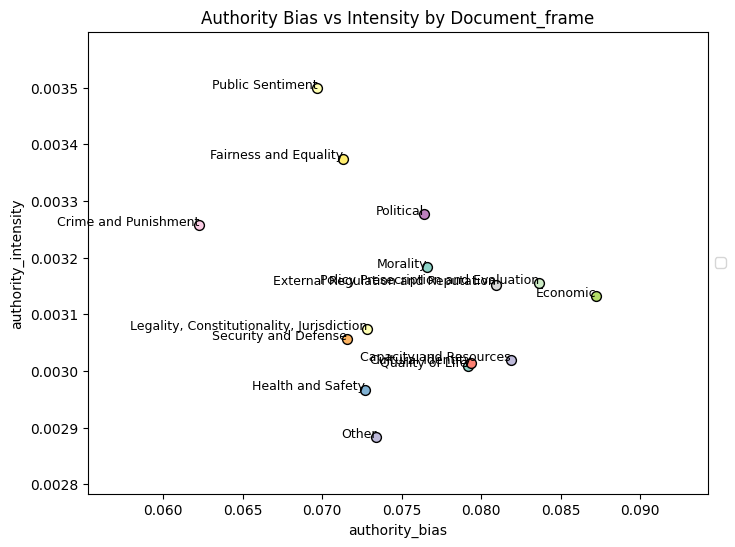

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


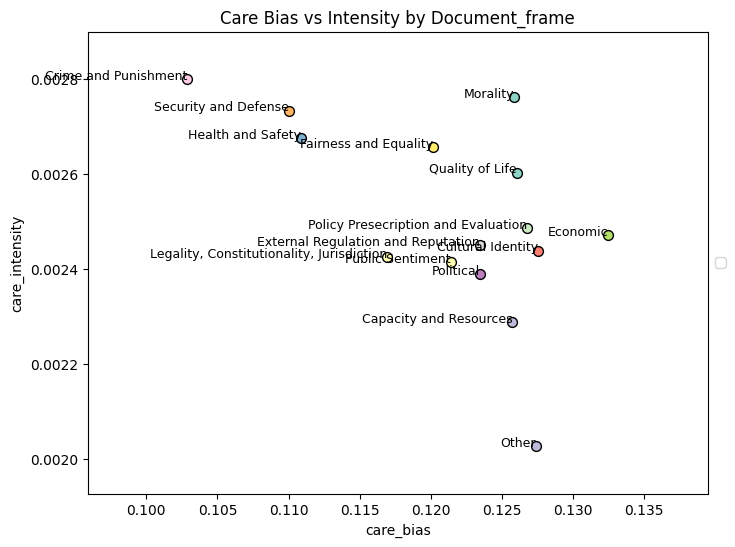

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


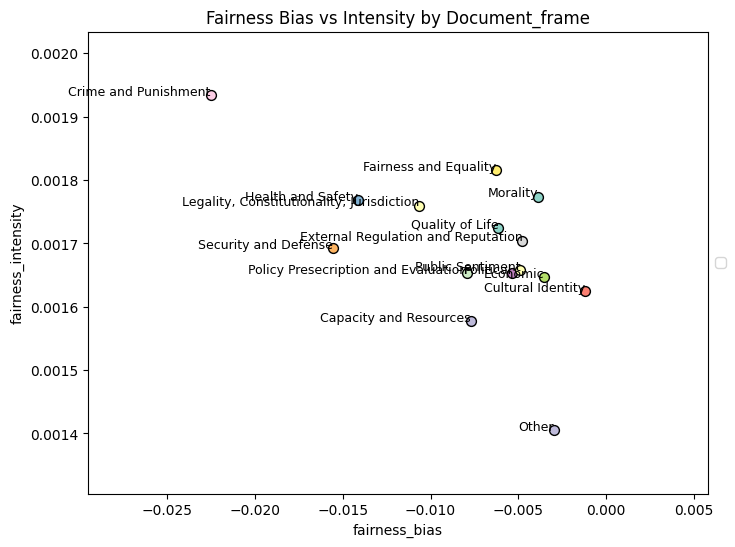

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


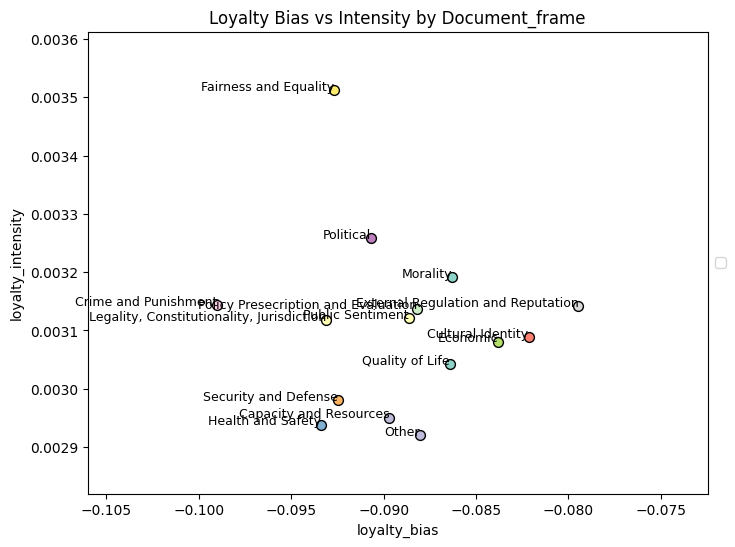

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


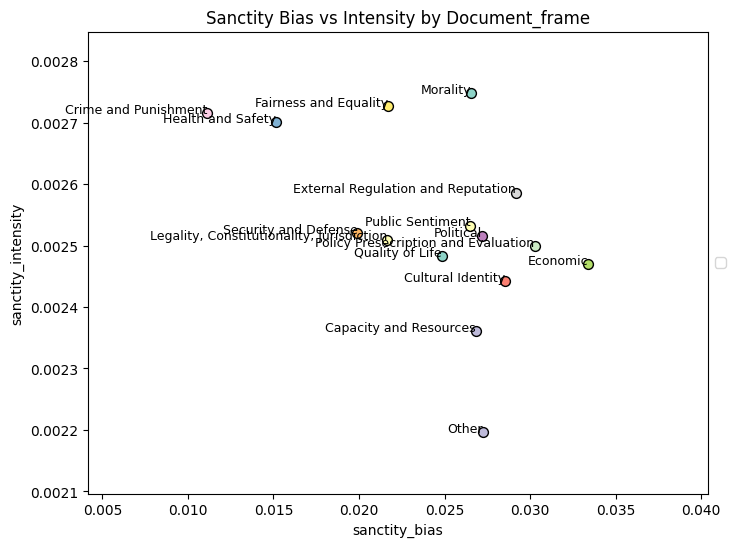

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_pair(df, pair, group_by=['frame_tone'], plot_density={}, tones=['pro', 'anti'], example_plot_value={}):
    # Filter the DataFrame for the tones we are interested in
    df_filtered = df[df['tone'].isin(tones)]
    
    # Set up plot
    plt.figure(figsize=(8, 6))
    
    # List to store points and their labels for later plotting
    points_with_labels = []

    # Iterate over each group type
    for group_type in group_by:
        if group_type in df.columns:
            # Process each unique group within the group type
            unique_groups = df_filtered[group_type].unique()
            for group_name in unique_groups:
                group_data = df_filtered[df_filtered[group_type] == group_name]
                
                # Calculate average values for the pair
                avg_bias = group_data[f'{pair}_bias'].mean()
                avg_intensity = group_data[f'{pair}_intensity'].mean()
                
                # Save the point and label for plotting
                points_with_labels.append((avg_bias, avg_intensity, group_name))

                # Extract bias and intensity for KDE plot
                bias_values = group_data[f'{pair}_bias']
                intensity_values = group_data[f'{pair}_intensity']

                if plot_density.get(group_type, False):
                    # KDE plot for the group
                    color = sns.color_palette('Set3')[len(points_with_labels) % len(sns.color_palette('Set3'))]
                    sns.kdeplot(x=bias_values, y=intensity_values, cmap=sns.light_palette(color, as_cmap=True),
                                fill=True, thresh=0.8, levels=10, alpha=0.8, bw_adjust=0.5)

    # Plot points and their labels
    for bias, intensity, label in points_with_labels:
        plt.scatter(bias, intensity, color=sns.color_palette('Set3')[points_with_labels.index((bias, intensity, label)) % len(sns.color_palette('Set3'))], s=50, edgecolor='black')
        plt.text(bias, intensity, label, fontsize=9, ha='right')

    if "x" in example_plot_value and "y" in example_plot_value and "label" in example_plot_value:
        print(f"Plotting example point: {example_plot_value['label']} at ({example_plot_value['x']}, {example_plot_value['y']})")

        points_with_labels.append((example_plot_value["x"], example_plot_value["y"], example_plot_value["label"]))

        # Plot the example point
        plt.scatter(example_plot_value["x"], example_plot_value["y"], color='red', s=50, edgecolor='black')
        plt.text(example_plot_value["x"], example_plot_value["y"], example_plot_value["label"], fontsize=9, ha='right')

    # Adjusting plot limits to fit all points comfortably
    plt.xlim([min([p[0] for p in points_with_labels]) - 0.007, max([p[0] for p in points_with_labels]) + 0.007])
    plt.ylim([min([p[1] for p in points_with_labels]) - 0.0001, max([p[1] for p in points_with_labels]) + 0.0001])

    # Add labels and legend
    plt.xlabel(f'{pair}_bias')
    plt.ylabel(f'{pair}_intensity')
    plt.title(f'{pair.capitalize()} Bias vs Intensity by {", ".join(group_by).capitalize()}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show plot
    plt.show()


# Example usage:
plot_pair(df_merged, 'authority', group_by=['document_frame'], plot_density={ 'document_frame': False }, tones=['pro', 'anti']) 
plot_pair(df_merged, 'care', group_by=['document_frame'], plot_density={ 'document_frame': False}, tones=['pro', 'anti'])
plot_pair(df_merged, 'fairness', group_by=['document_frame'], plot_density={ 'document_frame': False}, tones=['pro', 'anti'])
plot_pair(df_merged, 'loyalty', group_by=['document_frame'], plot_density={ 'document_frame': False}, tones=['pro', 'anti'])
plot_pair(df_merged, 'sanctity', group_by=['document_frame'], plot_density={ 'document_frame': False}, tones=['pro', 'anti'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


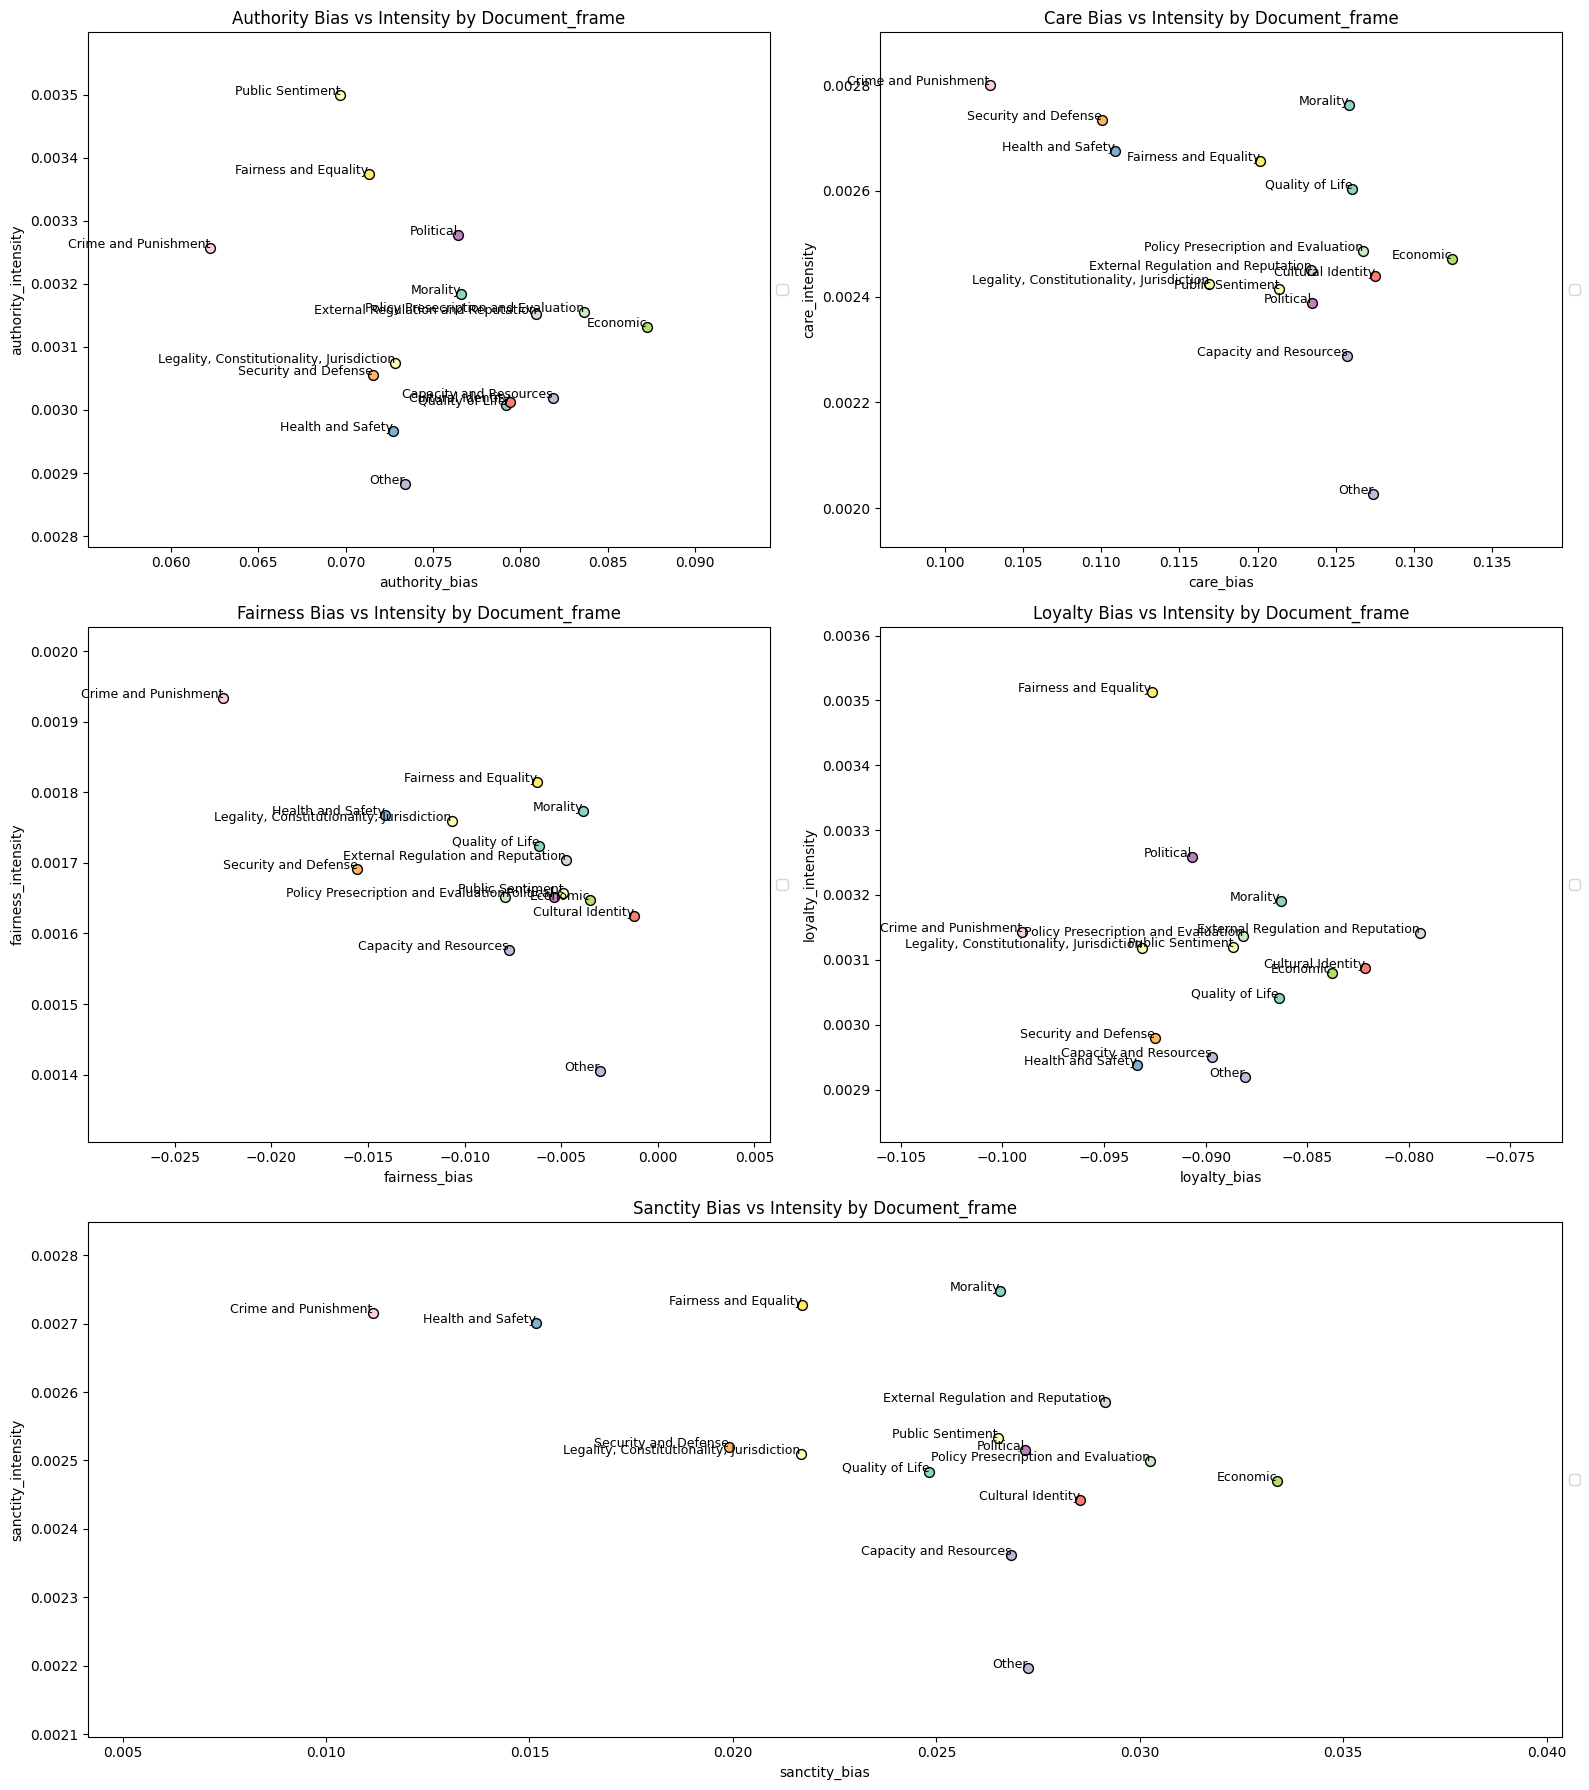

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_pair(df, pair, group_by=['frame_tone'], plot_density={}, tones=['pro', 'anti'], example_plot_value={}, ax=None):
    # Filter the DataFrame for the tones we are interested in
    df_filtered = df[df['tone'].isin(tones)]
    
    # Set up plot in provided axis
    if ax is None:
        ax = plt.gca()
    
    points_with_labels = []

    for group_type in group_by:
        if group_type in df.columns:
            unique_groups = df_filtered[group_type].unique()
            for group_name in unique_groups:
                group_data = df_filtered[df_filtered[group_type] == group_name]
                
                avg_bias = group_data[f'{pair}_bias'].mean()
                avg_intensity = group_data[f'{pair}_intensity'].mean()
                
                points_with_labels.append((avg_bias, avg_intensity, group_name))

                bias_values = group_data[f'{pair}_bias']
                intensity_values = group_data[f'{pair}_intensity']

                if plot_density.get(group_type, False):
                    color = sns.color_palette('Set3')[len(points_with_labels) % len(sns.color_palette('Set3'))]
                    sns.kdeplot(x=bias_values, y=intensity_values, cmap=sns.light_palette(color, as_cmap=True),
                                fill=True, thresh=0.8, levels=10, alpha=0.8, bw_adjust=0.5, ax=ax)

    for bias, intensity, label in points_with_labels:
        ax.scatter(bias, intensity, color=sns.color_palette('Set3')[points_with_labels.index((bias, intensity, label)) % len(sns.color_palette('Set3'))], s=50, edgecolor='black')
        ax.text(bias, intensity, label, fontsize=9, ha='right')

    if "x" in example_plot_value and "y" in example_plot_value and "label" in example_plot_value:
        points_with_labels.append((example_plot_value["x"], example_plot_value["y"], example_plot_value["label"]))
        ax.scatter(example_plot_value["x"], example_plot_value["y"], color='red', s=50, edgecolor='black')
        ax.text(example_plot_value["x"], example_plot_value["y"], example_plot_value["label"], fontsize=9, ha='right')

    ax.set_xlim([min([p[0] for p in points_with_labels]) - 0.007, max([p[0] for p in points_with_labels]) + 0.007])
    ax.set_ylim([min([p[1] for p in points_with_labels]) - 0.0001, max([p[1] for p in points_with_labels]) + 0.0001])

    ax.set_xlabel(f'{pair}_bias')
    ax.set_ylabel(f'{pair}_intensity')
    ax.set_title(f'{pair.capitalize()} Bias vs Intensity by {", ".join(group_by).capitalize()}')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Create a figure with 2 columns and 3 rows, but make last plot span two columns
plt.figure(figsize=(16, 18))
pairs = ['authority', 'care', 'fairness', 'loyalty', 'sanctity']
for i, pair in enumerate(pairs):
    if i < 4:
        ax = plt.subplot(3, 2, i+1)
    else:
        ax = plt.subplot(3, 2, (i+1, i+3))  # Make the last plot span two columns
    plot_pair(df_merged, pair, group_by=['document_frame'], plot_density={'document_frame': False}, tones=['pro', 'anti'], ax=ax)

plt.tight_layout()
plt.show()


### Plot Pair for single document_frame

document_frame
Crime and Punishment    803
Name: count, dtype: int64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting example point: Immigration1.0-17401 - Crime and Punishment - anti at (0.0795628402422975, 0.003424749412206297)


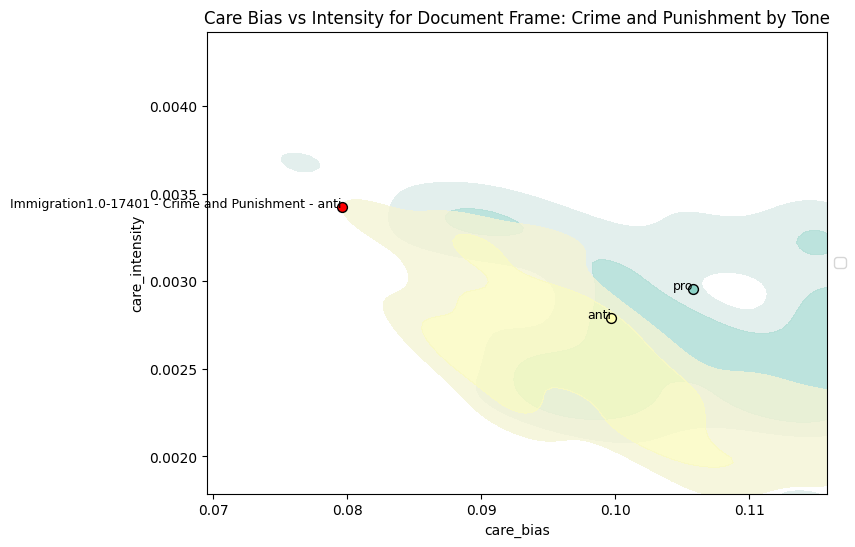

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pair_by_tone_within_frame(df, pair, document_frame, plot_density=True, tones=['pro', 'anti'], example_plot_value={}):
    # Filter the DataFrame for the specified document frame
    df_filtered = df[df['document_frame'] == document_frame]

    print(df_filtered["document_frame"].value_counts())
    
    # Set up plot
    plt.figure(figsize=(8, 6))
    
    # Initialize a list to keep track of points for plot limits
    points_with_labels = []

    # Iterate over each specified tone within the document frame
    for tone in tones:
        tone_data = df_filtered[df_filtered['tone'] == tone]
        
        # Calculate average values for the pair
        avg_bias = tone_data[f'{pair}_bias'].mean()
        avg_intensity = tone_data[f'{pair}_intensity'].mean()
        
        # Save the average point and label for plotting
        points_with_labels.append((avg_bias, avg_intensity, tone))
        
        # Extract bias and intensity for KDE plot if required
        bias_values = tone_data[f'{pair}_bias']
        intensity_values = tone_data[f'{pair}_intensity']

        color = sns.color_palette('Set3')[tones.index(tone) % len(sns.color_palette('Set3'))]  # Color by tone index

        if plot_density:
            sns.kdeplot(x=bias_values, y=intensity_values, cmap=sns.light_palette(color, as_cmap=True),
                        fill=True, thresh=0.5, levels=3, alpha=0.8, bw_adjust=0.5)

        # Plot the average point and label
        plt.scatter(avg_bias, avg_intensity, color=color, s=50, edgecolor='black')
        plt.text(avg_bias, avg_intensity, tone, fontsize=9, ha='right')

    if "x" in example_plot_value and "y" in example_plot_value and "label" in example_plot_value:
        print(f"Plotting example point: {example_plot_value['label']} at ({example_plot_value['x']}, {example_plot_value['y']})")
        points_with_labels.append((example_plot_value["x"], example_plot_value["y"], example_plot_value["label"]))

        # Plot the example point
        plt.scatter(example_plot_value["x"], example_plot_value["y"], color='red', s=50, edgecolor='black')
        plt.text(example_plot_value["x"], example_plot_value["y"], example_plot_value["label"], fontsize=9, ha='right')

    # Adjusting plot limits to fit all points comfortably
    plt.xlim([min([p[0] for p in points_with_labels]) - 0.01, max([p[0] for p in points_with_labels]) + 0.01])
    plt.ylim([min([p[1] for p in points_with_labels]) - 0.001, max([p[1] for p in points_with_labels]) + 0.001])

    # Add labels and legend
    plt.xlabel(f'{pair}_bias')
    plt.ylabel(f'{pair}_intensity')
    plt.title(f'{pair.capitalize()} Bias vs Intensity for Document Frame: {document_frame} by Tone')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show plot
    plt.show()


# Example usage:
plot_pair_by_tone_within_frame(df, 'care', document_frame='Crime and Punishment', tones=['pro', 'anti'], example_plot_value=care_example_value_article)

### Plot Pair for single document_frame for all foundations in a single plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


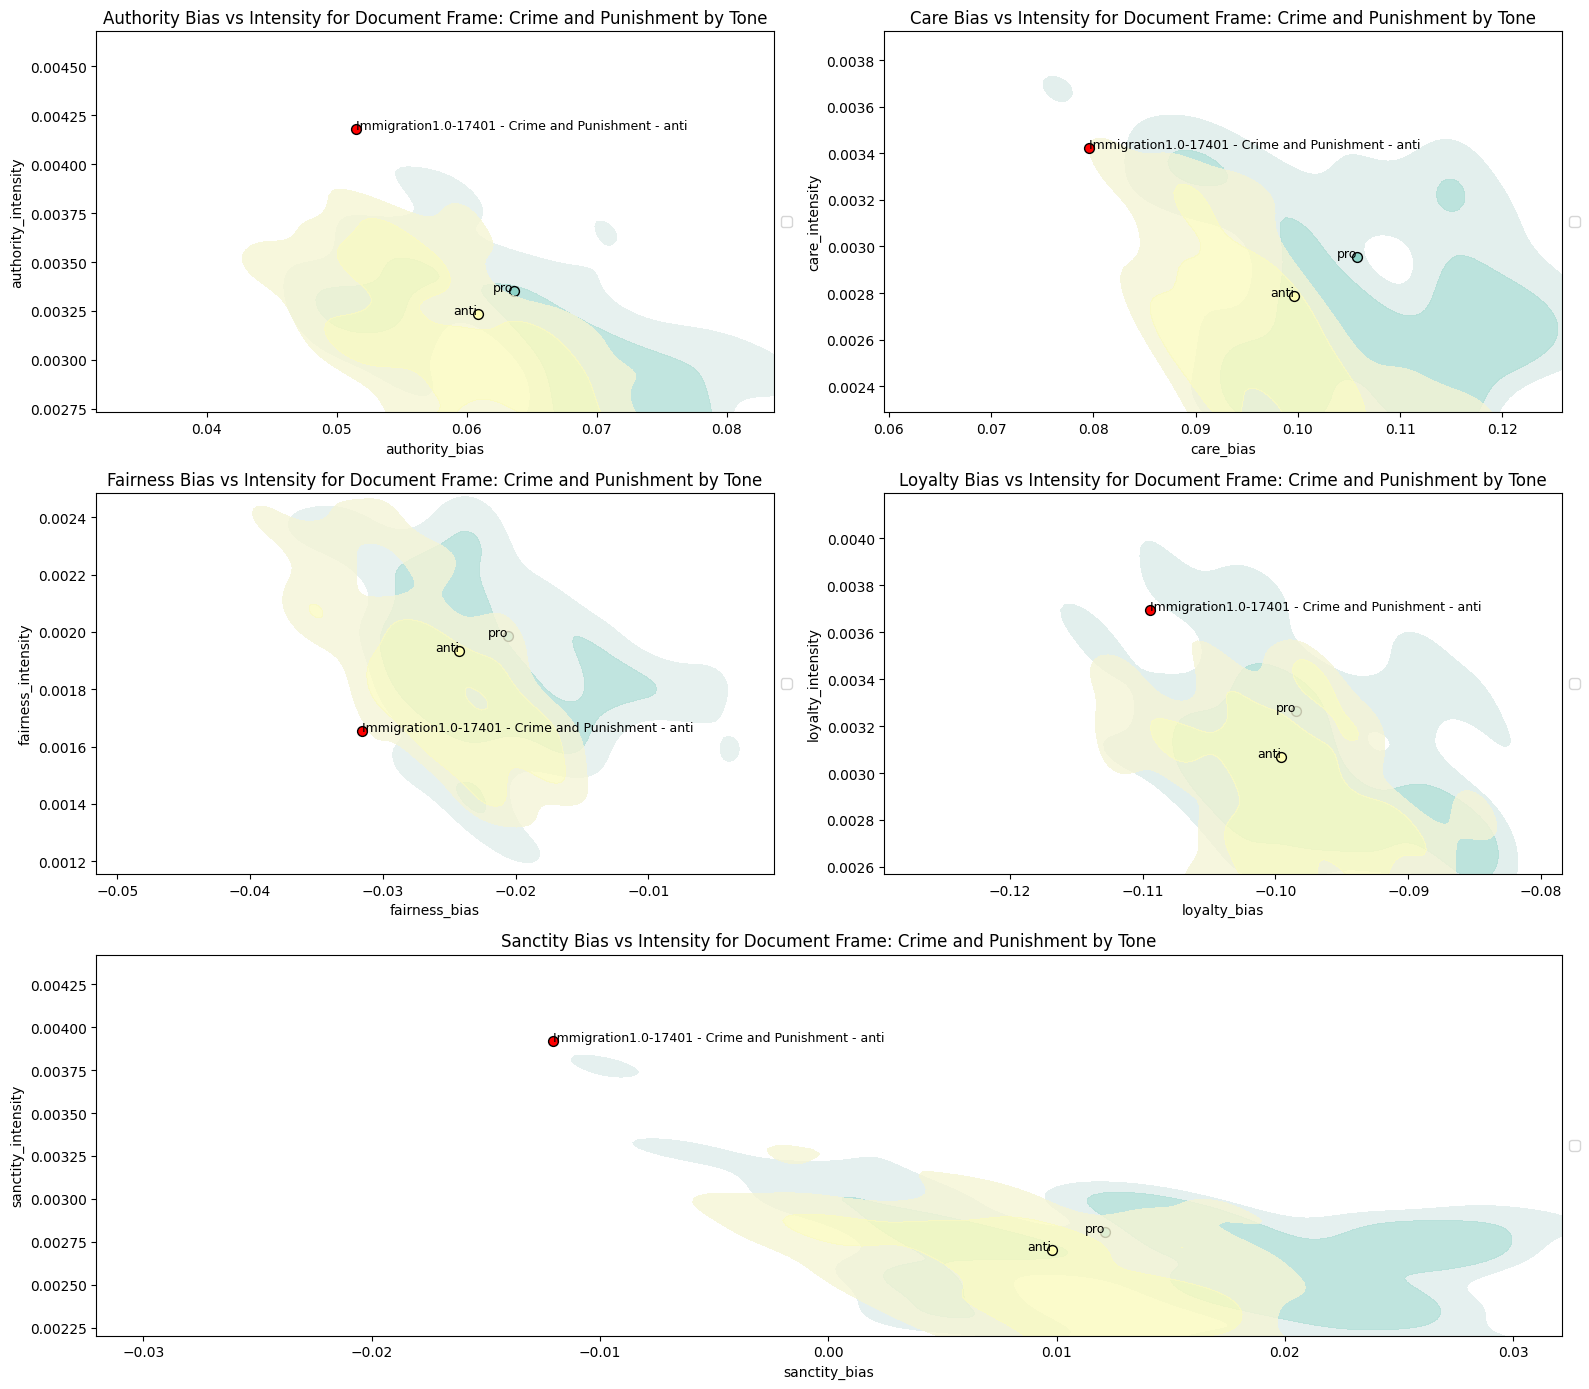

In [94]:
from matplotlib import gridspec

def plot_pairs_by_tone_within_frame(df, pairs, document_frame, plot_density=True, tones=['pro', 'anti'], example_plot_values={}):
    # Set up the subplot grid
    fig = plt.figure(figsize=(16, 14))
    gs = gridspec.GridSpec(3, 2)

    # Define subplot placement
    axes = []
    for i in range(4):
        row = i // 2
        col = i % 2
        axes.append(fig.add_subplot(gs[row, col]))
    # Add the last subplot which spans both columns in the last row
    axes.append(fig.add_subplot(gs[2, :]))


    # Iterate over each pair and plot
    for i, pair in enumerate(pairs):
        ax = axes[i]
        # Filter the DataFrame for the specified document frame
        df_filtered = df[df['document_frame'] == document_frame]

        # Initialize a list to keep track of points for plot limits
        points_with_labels = []

        # Iterate over each specified tone within the document frame
        for tone in tones:
            tone_data = df_filtered[df_filtered['tone'] == tone]

            # Calculate average values for the pair
            avg_bias = tone_data[f'{pair}_bias'].mean()
            avg_intensity = tone_data[f'{pair}_intensity'].mean()

            # Save the average point and label for plotting
            points_with_labels.append((avg_bias, avg_intensity, tone))

            # Extract bias and intensity for KDE plot if required
            bias_values = tone_data[f'{pair}_bias']
            intensity_values = tone_data[f'{pair}_intensity']

            color = sns.color_palette('Set3')[tones.index(tone) % len(sns.color_palette('Set3'))]  # Color by tone index

            if plot_density:
                sns.kdeplot(x=bias_values, y=intensity_values, cmap=sns.light_palette(color, as_cmap=True),
                            fill=True, thresh=0.5, levels=3, alpha=0.8, bw_adjust=0.5, ax=ax)

            # Plot the average point and label
            ax.scatter(avg_bias, avg_intensity, color=color, s=50, edgecolor='black')
            ax.text(avg_bias, avg_intensity, tone, fontsize=9, ha='right')

        example_plot_value = example_plot_values.get(pair, {})
        if "x" in example_plot_value and "y" in example_plot_value and "label" in example_plot_value:
            # Plot the example point
            ax.scatter(example_plot_value["x"], example_plot_value["y"], color='red', s=50, edgecolor='black')
            ax.text(example_plot_value["x"], example_plot_value["y"], example_plot_value["label"], fontsize=9, ha='left')

            points_with_labels.append((example_plot_value["x"], example_plot_value["y"], example_plot_value["label"]))

        # Adjusting plot limits to fit all points comfortably
        ax.set_xlim([min([p[0] for p in points_with_labels]) - 0.02, max([p[0] for p in points_with_labels]) + 0.02])
        ax.set_ylim([min([p[1] for p in points_with_labels]) - 0.0005, max([p[1] for p in points_with_labels]) + 0.0005])

        # Add labels and title
        ax.set_xlabel(f'{pair}_bias')
        ax.set_ylabel(f'{pair}_intensity')
        ax.set_title(f'{pair.capitalize()} Bias vs Intensity for Document Frame: {document_frame} by Tone')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
pairs = ['authority', 'care', 'fairness', 'loyalty', 'sanctity']
example_plot_values = {
    'authority': authority_example_value_article,
    'care': care_example_value_article,
    'fairness': fairness_example_value_article,
    'loyalty': loyalty_example_value_article,
    'sanctity': sanctity_example_value_article
}
plot_pairs_by_tone_within_frame(df, pairs, 'Crime and Punishment', tones=['pro', 'anti'], example_plot_values=example_plot_values)

### Microframe Bias and Intensity Shift per Word

In [42]:
contributions_file_name = "frameaxis_mft_blacklist_contributions"

In [43]:
import pandas as pd
import json

In [44]:
# read data\frameaxis\mfc\frameaxis_mft_contributions.pkl

df_wc = pd.read_pickle(f"../../data/frameaxis/mfc/{contributions_file_name}.pkl")

df_wc.set_index('article_id', inplace=True)

# load raw articles to get tone
imm_df = pd.DataFrame(json.load(open(immigration_path)))

# prepare immigration articles
imm_df = imm_df.T

# join the dataframes by article_id keeping the df_wc rows order
df_wc = df_wc.join(imm_df['primary_tone'], how='left')

In [45]:
tone_mapping = {
    17: "pro",
    18: "neutral",
    19: "anti"
}


df_wc['primary_tone'] = df_wc['primary_tone'].map(tone_mapping)
df_wc['primary_tone'] = df_wc['primary_tone'].where(df_wc['primary_tone'].isin(tone_mapping.values()))

In [46]:
# concat primary_tone and document_frame to create frame_tone
df_wc["frame_tone"] = df_wc["document_frame"] + " - " + df_wc["primary_tone"]

df_wc["primary_tone"] = pd.Categorical(df_wc["primary_tone"], categories=["pro", "neutral", "anti", "nan"], ordered=True)

In [47]:
# loop over df and find immigration as key in word_contributions col which is a list
from collections import Counter 

word_blacklist=["immigrant", "immigration", "illegal", "legal"]

variants = []
for idx, row in df_wc.iterrows():
    for d in row["word_contributions"]:
        for word in word_blacklist:
            if word in d["word"]:
                variants.append(d["word"])

# print unique with count per variant
print(Counter(variants))


Counter({'legalization': 120, 'legalizing': 38, 'legality': 28, 'legalized': 24, 'nonimmigrant': 17, 'immigrations': 13, 'illegality': 12, 'paralegal': 9, 'paralegals': 7, 'legals': 7, 'nonimmigrants': 6, 'legalese': 2, 'immigrantrights': 2, 'metroillegal': 2, 'legalizes': 2, 'southeasternlegal': 1, 'legaland': 1, 'immigrationcrackdown': 1, 'immigrationfrom': 1, 'legalizetheirish': 1, 'ilegal': 1, 'usimmigrationsupport': 1, 'legalistic': 1, 'immigrationand': 1, 'immigrationmetro': 1, 'onimmigration': 1, 'legalities': 1, 'immigrationreform': 1, 'ofimmigrants': 1, 'legalism': 1})


In [48]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_contributions(contributions):
    for contribution in contributions:
        # Lemmatize the 'word' key in each dictionary
        contribution['word'] = lemmatizer.lemmatize(contribution['word'])
    return contributions

df_wc['word_contributions'] = df_wc['word_contributions'].apply(lemmatize_contributions)

In [49]:
group_by_col = "frame_tone"

In [50]:
def calculate_bias_shifts(data):
    # Initialize a dictionary to hold cumulative scores and counts
    contributions = {}
    total_counts = {'authority': 0, 'care': 0, 'fairness': 0, 'loyalty': 0, 'sanctity': 0}

    # Loop through each row's contribution data
    for contributions_list in data:
        for word_data in contributions_list:
            word = word_data['word']
            if word not in contributions:
                contributions[word] = {
                    'authority': {'values': [], 'sum': 0, 'count': 0},
                    'care': {'values': [], 'sum': 0, 'count': 0},
                    'fairness': {'values': [], 'sum': 0, 'count': 0},
                    'loyalty': {'values': [], 'sum': 0, 'count': 0},
                    'sanctity': {'values': [], 'sum': 0, 'count': 0}
                }
            # Append the bias values for each microframe and update sum and count
            for frame in ['authority', 'care', 'fairness', 'loyalty', 'sanctity']:
                bias_value = word_data.get(frame, 0)
                if bias_value != 0:  # Only count non-zero contributions
                    contributions[word][frame]['values'].append(bias_value)
                    contributions[word][frame]['sum'] += bias_value
                    contributions[word][frame]['count'] += 1
                    total_counts[frame] += 1

    # Calculate averages and prepare output with sum and count
    results = {}
    for word, frames in contributions.items():
        results[word] = {}
        for frame, details in frames.items():
            avg = details['sum'] / total_counts[frame]
            results[word][frame] = {
                'average': avg,
                'sum': details['sum'],
                'count': details['count']
            }

    return results

# Apply the function to each group of document frame
bias_shift_grouped = df_wc.groupby(group_by_col)['word_contributions'].apply(calculate_bias_shifts)

In [51]:
# Microframe lists
microframe_data = {
    'authority_bias_background': [],
    'care_bias_background': [],
    'fairness_bias_background': [],
    'loyalty_bias_background': [],
    'sanctity_bias_background': []
}

# Function to parse contributions and accumulate values for each microframe
def accumulate_contributions(row):
    for contribution in row:
        for frame, value in contribution.items():
            frame = f"{frame}_bias_background"
            if frame in microframe_data:
                microframe_data[frame].append(value)

# Process each row
df_wc['word_contributions'].apply(accumulate_contributions)

# Calculate the mean for each microframe and store in a dictionary
background_biases = {frame: sum(values) / len(values) for frame, values in microframe_data.items() if values}

# Creating the DataFrame of background biases
df_background_bias = pd.DataFrame(list(background_biases.items()), columns=['microframe', 'background_bias'])

# T the df, drop first row and first col
df_background_bias = df_background_bias.T
df_background_bias.columns = df_background_bias.iloc[0]
df_background_bias = df_background_bias[1:]

In [52]:
df_background_bias

microframe      authority_bias_background care_bias_background  \
background_bias                  0.079328             0.117862   

microframe      fairness_bias_background loyalty_bias_background  \
background_bias                -0.009852               -0.084509   

microframe      sanctity_bias_background  
background_bias                 0.025326

In [53]:
def calculate_intensity_shifts(group, background_biases):
    contributions = {}
    total_counts = {'authority': 0, 'care': 0, 'fairness': 0, 'loyalty': 0, 'sanctity': 0}

    # Loop through each entry in the group
    for word_contributions in group:
        for word_data in word_contributions:
            word = word_data['word']
            if word not in contributions:
                contributions[word] = {
                    'authority': {'values': [], 'sum': 0, 'count': 0},
                    'care': {'values': [], 'sum': 0, 'count': 0},
                    'fairness': {'values': [], 'sum': 0, 'count': 0},
                    'loyalty': {'values': [], 'sum': 0, 'count': 0},
                    'sanctity': {'values': [], 'sum': 0, 'count': 0}
                }
            # Calculate the intensity shift for each microframe and append
            for frame in ['authority', 'care', 'fairness', 'loyalty', 'sanctity']:
                ca_w = word_data.get(frame, 0)
                Bf = background_biases.get(f'{frame}_bias_background', 0)
                if ca_w != 0:  # Only consider non-zero contributions for calculating
                    shift = (ca_w - Bf) ** 2
                    contributions[word][frame]['values'].append(shift)
                    contributions[word][frame]['sum'] += shift
                    contributions[word][frame]['count'] += 1
                    total_counts[frame] += 1

    # Calculate the normalized intensity for each word based on the total counts of each frame
    results = {}
    for word, frames in contributions.items():
        results[word] = {}
        for frame, frame_details in frames.items():
            if frame_details['count'] > 0:
                average = frame_details['sum'] / total_counts[frame]
            else:
                average = 0
            results[word][frame] = {
                'average': average,
                'sum': frame_details['sum'],
                'count': frame_details['count']
            }

    return results

# Apply the function for each document frame group
intensity_shift_grouped = df_wc.groupby(group_by_col)['word_contributions'].apply(lambda x: calculate_intensity_shifts(x, background_biases))

In [54]:
data = []
for (doc_frame, word), intensities in intensity_shift_grouped.items():
    # if shift type = float print
    if isinstance(intensities, float):
        # ignore
        continue

    for microframe, shift in intensities.items():
        data.append({
            group_by_col: doc_frame,
            'word': word,
            'microframe': microframe,
            'intensity_shift': shift["average"],
            'intensity_sum': shift["sum"],
            'intensity_count': shift["count"]
        })

df_intensities = pd.DataFrame(data)

In [55]:
df_intensities

frame_tone    word microframe  intensity_shift  \
0       Capacity and Resources - anti     per  authority     3.524611e-07   
1       Capacity and Resources - anti     per       care     1.706256e-06   
2       Capacity and Resources - anti     per   fairness     5.378140e-07   
3       Capacity and Resources - anti     per    loyalty     2.331501e-06   
4       Capacity and Resources - anti     per   sanctity     3.500641e-06   
...                               ...     ...        ...              ...   
818485     Security and Defense - pro  haddam  authority     2.743243e-06   
818486     Security and Defense - pro  haddam       care     3.277814e-07   
818487     Security and Defense - pro  haddam   fairness     7.486024e-07   
818488     Security and Defense - pro  haddam    loyalty     2.567705e-06   
818489     Security and Defense - pro  haddam   sanctity     1.165969e-06   

        intensity_sum  intensity_count  
0            0.002513                3  
1            0.012167                3  
2            0.003835                3  
3            0.016626                3  
4            0.024963                3  
...               ...              ...  
818485       0.011469                4  
818486       0.001370                4  
818487       0.003130                4  
818488       0.010736                4  
818489       0.004875                4  

[818490 rows x 6 columns]

In [56]:
data = []
for (doc_frame, word), biases in bias_shift_grouped.items():
    # if shift type = float print
    if isinstance(biases, float):
        # ignore
        continue

    for microframe, bias in biases.items():
        data.append({
            group_by_col: doc_frame,
            'word': word,
            'microframe': microframe,
            'bias_shift': bias["average"],
            'bias_sum': bias["sum"],
            'bias_count': bias["count"]
        })

df_bias = pd.DataFrame(data)

In [57]:
df_bias

frame_tone    word microframe  bias_shift  \
0       Capacity and Resources - anti     per  authority    0.000045   
1       Capacity and Resources - anti     per       care    0.000076   
2       Capacity and Resources - anti     per   fairness    0.000010   
3       Capacity and Resources - anti     per    loyalty   -0.000005   
4       Capacity and Resources - anti     per   sanctity    0.000047   
...                               ...     ...        ...         ...   
818485     Security and Defense - pro  haddam  authority    0.000030   
818486     Security and Defense - pro  haddam       care    0.000097   
818487     Security and Defense - pro  haddam   fairness    0.000013   
818488     Security and Defense - pro  haddam    loyalty   -0.000104   
818489     Security and Defense - pro  haddam   sanctity    0.000006   

        bias_sum  bias_count  
0       0.321210           3  
1       0.543436           3  
2       0.070911           3  
3      -0.035508           3  
4       0.337423           3  
...          ...         ...  
818485  0.124932           4  
818486  0.405167           4  
818487  0.053305           4  
818488 -0.434614           4  
818489  0.024994           4  

[818490 rows x 6 columns]

In [58]:
import matplotlib.pyplot as plt

In [59]:
# calculate target specific background corpus bias
def get_background_word_shift_bias(df_bias, group_by_col="frame_tone"):
    # Get unique frames from the grouping column
    frames = df_bias[group_by_col].unique()

    # Initialize an empty DataFrame to store the background biases
    background_biases = pd.DataFrame()

    # Calculate background biases for each word not in the same document frame
    for doc_frame in frames:
        # Filter out data from the current document frame
        df_background = df_bias[df_bias[group_by_col] != doc_frame]

        full_grouped = df_background.groupby('microframe')
        count_data = full_grouped['bias_count'].sum().reset_index(name='count')
        
        # Group by word and microframe and calculate cumulative sum and count
        grouped_data = df_background.groupby(['word', 'microframe'])
        sum_data = grouped_data['bias_sum'].sum().reset_index(name='sum')

        # Merge sum and count data
        merged_data = pd.merge(sum_data, count_data, on=['microframe'])

        # Calculate the mean bias
        merged_data['bias_background'] = merged_data['sum'] / merged_data['count']
        
        # Assign the current document frame to which this background data applies
        merged_data[group_by_col] = doc_frame
        
        # Append the calculated background means to the overall DataFrame
        background_biases = pd.concat([background_biases, merged_data], ignore_index=True)

    # Select required columns to match the output structure
    background_biases = background_biases[['word', 'microframe', 'bias_background', group_by_col]]

    return background_biases

In [60]:
df_background_shift_bias = get_background_word_shift_bias(df_bias, group_by_col=group_by_col)

In [61]:
df_background_shift_bias[(df_background_shift_bias["word"] == "welcome") & (df_background_shift_bias["frame_tone"] == "Political - pro")]

word microframe  bias_background       frame_tone
5047169  welcome  authority         0.000021  Political - pro
5076377  welcome       care         0.000045  Political - pro
5105585  welcome   fairness         0.000007  Political - pro
5134793  welcome    loyalty        -0.000017  Political - pro
5164001  welcome   sanctity         0.000007  Political - pro

In [62]:
df_bias[(df_bias["word"] == "welcome") & (df_bias["frame_tone"] == "Economic - anti")]

frame_tone     word microframe  bias_shift  bias_sum  bias_count
218580  Economic - anti  welcome  authority    0.000044  0.645534           4
218581  Economic - anti  welcome       care    0.000072  1.056891           4
218582  Economic - anti  welcome   fairness    0.000009  0.135031           4
218583  Economic - anti  welcome    loyalty   -0.000012 -0.180401           4
218584  Economic - anti  welcome   sanctity    0.000019  0.278518           4

In [63]:
def get_background_word_shift_intensity(df_intensity, group_by_col="frame_tone"):
    # Convert 'intensity_shift' to numeric if it's not already
    df_intensity['intensity_shift'] = pd.to_numeric(df_intensity['intensity_shift'], errors='coerce')

    # Get unique frames from the grouping column
    frames = df_intensity[group_by_col].unique()

    # Initialize an empty DataFrame to store the background intensities
    background_intensities = pd.DataFrame()

    # Calculate background intensities for each word not in the same document frame
    for doc_frame in frames:
        # Filter out data from the current document frame
        df_background = df_intensity[df_intensity[group_by_col] != doc_frame]

        full_grouped = df_background.groupby('microframe')
        count_data = full_grouped['intensity_count'].sum().reset_index(name='count')
        
        # Group by word and microframe and calculate cumulative sum and count
        grouped_data = df_background.groupby(['word', 'microframe'])
        sum_data = grouped_data['intensity_sum'].sum().reset_index(name='sum')

        # Merge sum and count data
        merged_data = pd.merge(sum_data, count_data, on=['microframe'])

        # Calculate the mean intensity_count
        merged_data['intensity_background'] = merged_data['sum'] / merged_data['count']
        
        # Assign the current document frame to which this background data applies
        merged_data[group_by_col] = doc_frame
        
        # Append the calculated background means to the overall DataFrame
        background_intensities = pd.concat([background_intensities, merged_data], ignore_index=True)

    background_intensities = background_intensities[['word', 'microframe', 'intensity_background', group_by_col]]

    return background_intensities

In [64]:
df_background_shift_intensity = get_background_word_shift_intensity(df_intensities, group_by_col=group_by_col)

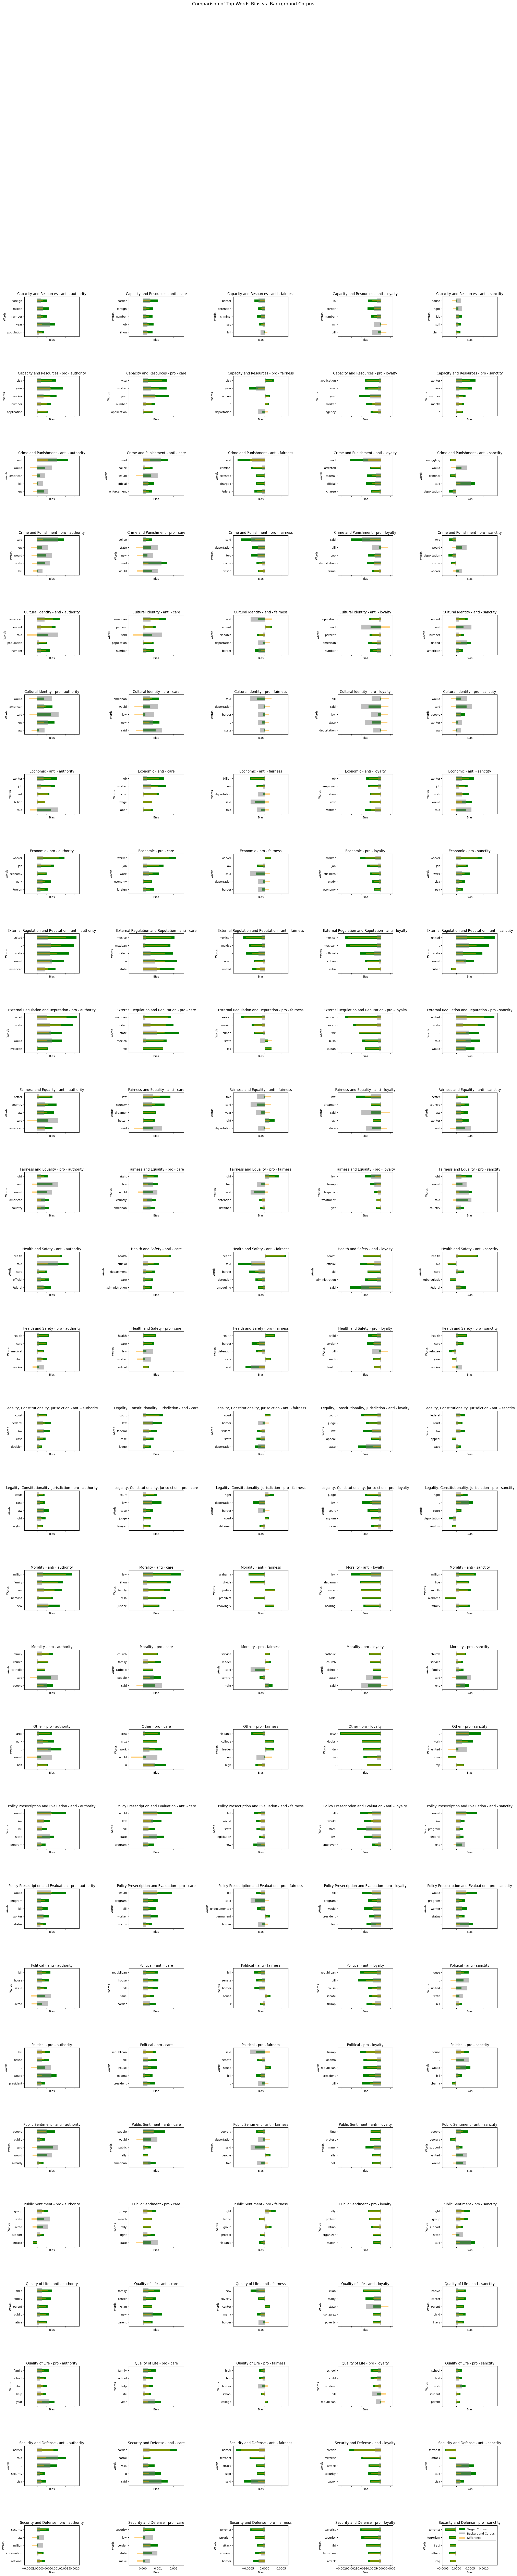

In [78]:
def plot_word_bias_comparisons(df_bias, df_background_shift_bias, selected_document_frames, selected_microframes, group_by_col="frame_tone", top_n=10):
    df_merged = df_bias.merge(df_background_shift_bias, on=[group_by_col, 'word', 'microframe']).rename(columns={'bias_shift': 'bias_target'})

    # add bias_difference
    df_merged['bias_difference'] = df_merged['bias_target'] - df_merged['bias_background']
    df_merged['abs_difference'] = df_merged['bias_difference'].abs()
 
    # Plot setup
    num_document_frames = len(selected_document_frames)
    num_microframes = len(selected_microframes)
    fig, axes = plt.subplots(num_document_frames, num_microframes, figsize=(num_microframes * 6, num_document_frames * 5), sharex='col')
    fig.subplots_adjust(hspace=1.0, wspace=0.9)

    # Ensure axes are always in a 2D array format
    if num_document_frames == 1 and num_microframes == 1:
        axes = np.array([[axes]])
    elif num_document_frames == 1:
        axes = np.array([axes])
    elif num_microframes == 1:
        axes = axes[:, np.newaxis]

    # Plotting
    for frame_index, doc_frame in enumerate(selected_document_frames):
        for microframe_index, microframe in enumerate(selected_microframes):
            ax = axes[frame_index, microframe_index]

            # get top_words for the selected document frame and microframe
            top_words = df_merged[(df_merged[group_by_col] == doc_frame) & (df_merged['microframe'] == microframe)].nlargest(top_n, 'abs_difference')

            # reverse the order of the top_words
            top_words = top_words.iloc[::-1]

            bar_width = 0.3

            # Plot target corpus biases
            ax.barh(top_words['word'], top_words['bias_target'], height=bar_width, color='green', label='Target Corpus')

            # Plot background biases for these top words
            ax.barh(top_words['word'], top_words['bias_background'], height=bar_width*2, color='gray', alpha=0.5, label='Background Corpus')

            # Plot difference
            ax.barh(top_words['word'], top_words['bias_difference'], height=bar_width/2, color='orange', alpha=0.5, label='Difference')

            ax.set_title(f"{doc_frame} - {microframe}")
            ax.set_xlabel('Bias')
            ax.set_ylabel('Words')

    # Legend handling
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.suptitle('Comparison of Top Words Bias vs. Background Corpus', fontsize=16)
    plt.show()


selected_frame_tone = ['Capacity and Resources - anti',
 'Capacity and Resources - pro',
 'Crime and Punishment - anti',
 'Crime and Punishment - pro',
 'Cultural Identity - anti',
 'Cultural Identity - pro',
 'Economic - anti',
 'Economic - pro',
 'External Regulation and Reputation - anti',
 'External Regulation and Reputation - pro',
 'Fairness and Equality - anti',
 'Fairness and Equality - pro',
 'Health and Safety - anti',
 'Health and Safety - pro',
 'Legality, Constitutionality, Jurisdiction - anti',
 'Legality, Constitutionality, Jurisdiction - pro',
 'Morality - anti',
 'Morality - pro',
 'Other - pro',
 'Policy Presecription and Evaluation - anti',
 'Policy Presecription and Evaluation - pro',
 'Political - anti',
 'Political - pro',
 'Public Sentiment - anti',
 'Public Sentiment - pro',
 'Quality of Life - anti',
 'Quality of Life - pro',
 'Security and Defense - anti',
 'Security and Defense - pro']

selected_frames = ['Quality of Life', 'Legality, Constitutionality, Jurisdiction',
       'Capacity and Resources', 'Cultural Identity', 'Health and Safety',
       'Security and Defense', 'Economic', 'Crime and Punishment',
       'External Regulation and Reputation', 'Political',
       'Fairness and Equality', 'Policy Presecription and Evaluation',
       'Morality', 'Public Sentiment', 'Other']
selected_microframes = ['authority', 'care', 'fairness', 'loyalty', 'sanctity']

plot_word_bias_comparisons(df_bias, df_background_shift_bias, selected_frame_tone, selected_microframes, group_by_col=group_by_col, top_n=5)

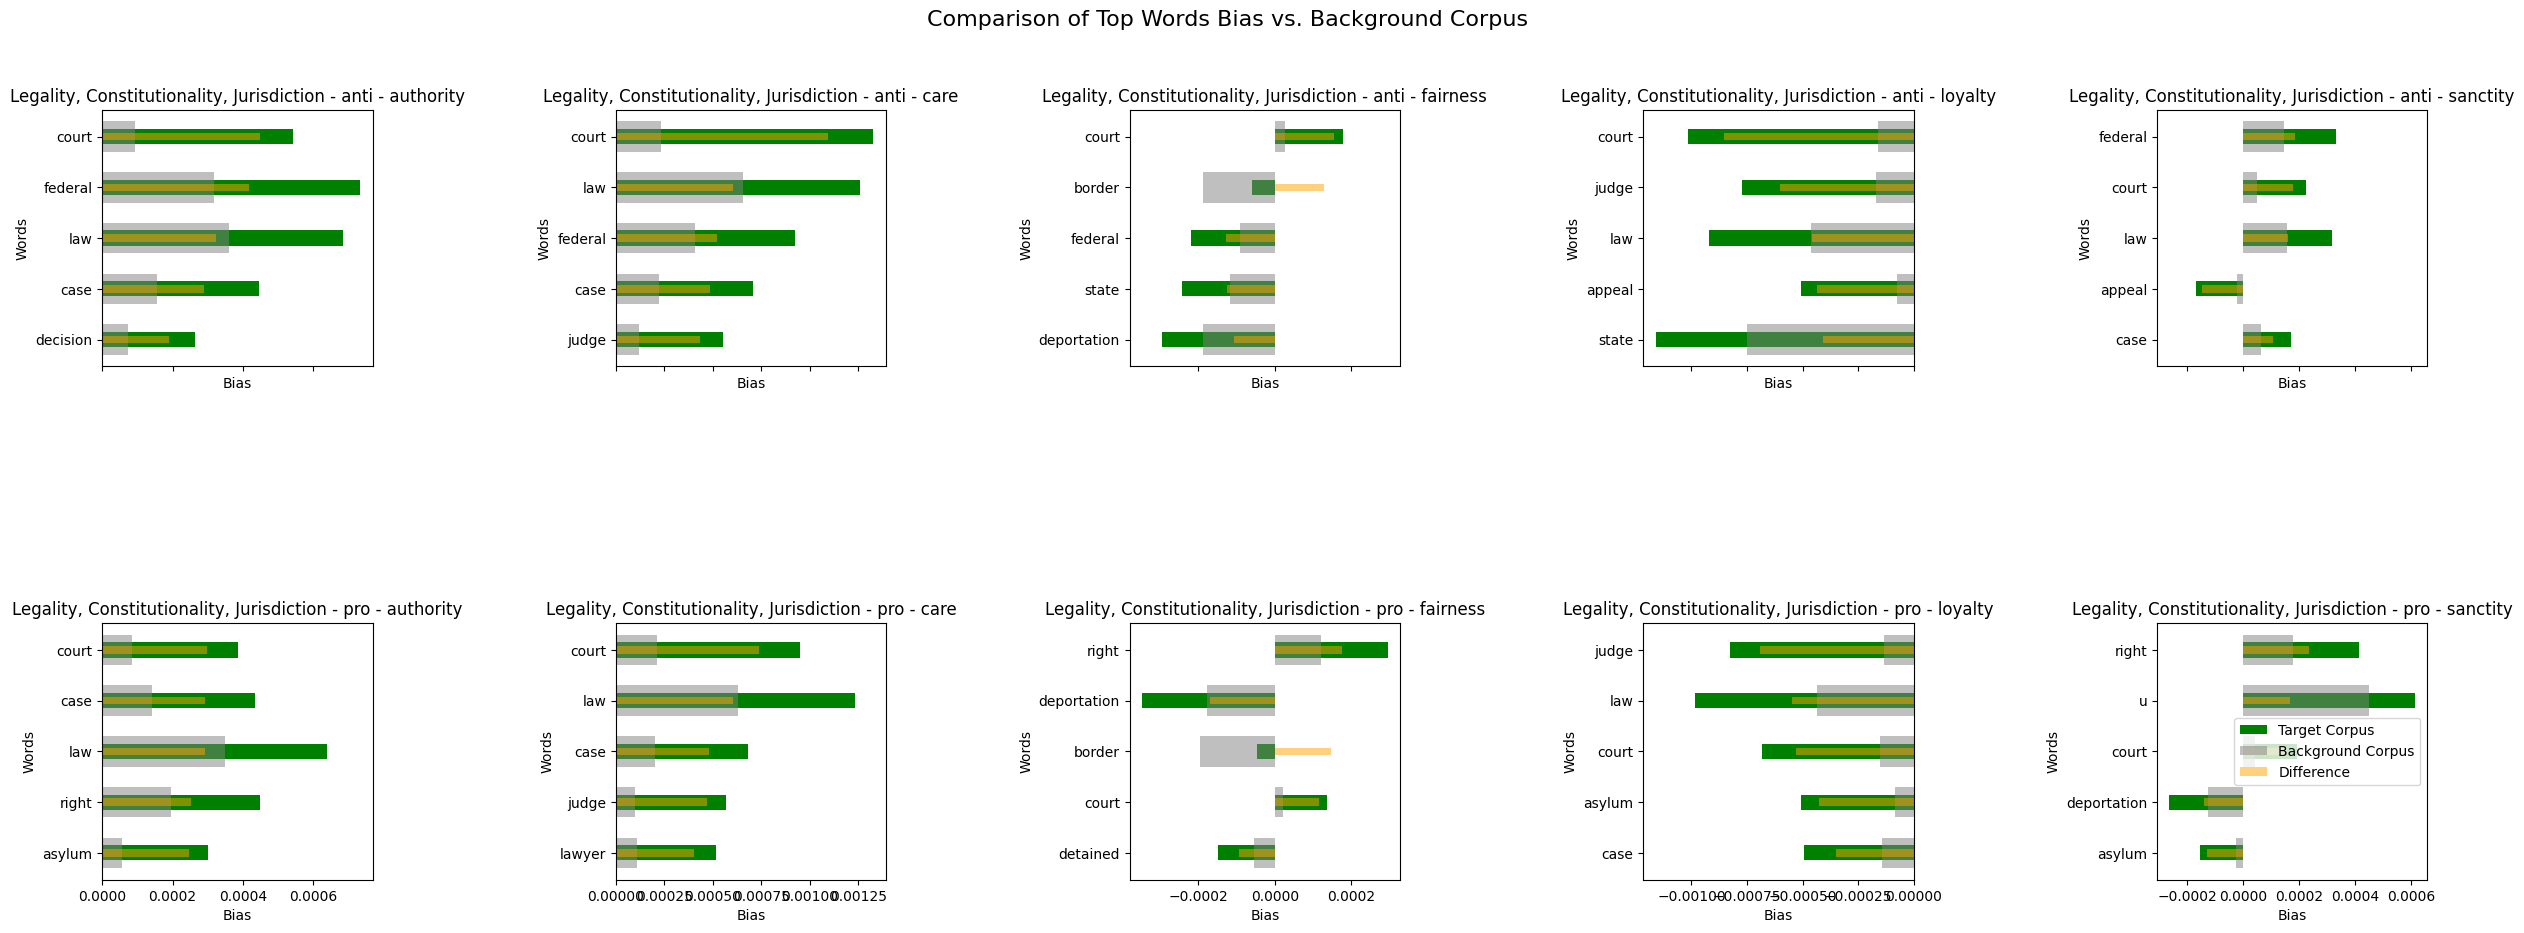

In [79]:
selected_frame_tone = ['Legality, Constitutionality, Jurisdiction - anti',
 'Legality, Constitutionality, Jurisdiction - pro',]

selected_frames = ['Quality of Life', 'Legality, Constitutionality, Jurisdiction',
       'Capacity and Resources', 'Cultural Identity', 'Health and Safety',
       'Security and Defense', 'Economic', 'Crime and Punishment',
       'External Regulation and Reputation', 'Political',
       'Fairness and Equality', 'Policy Presecription and Evaluation',
       'Morality', 'Public Sentiment', 'Other']
selected_microframes = ['authority', 'care', 'fairness', 'loyalty', 'sanctity']

plot_word_bias_comparisons(df_bias, df_background_shift_bias, selected_frame_tone, selected_microframes, group_by_col=group_by_col, top_n=5)

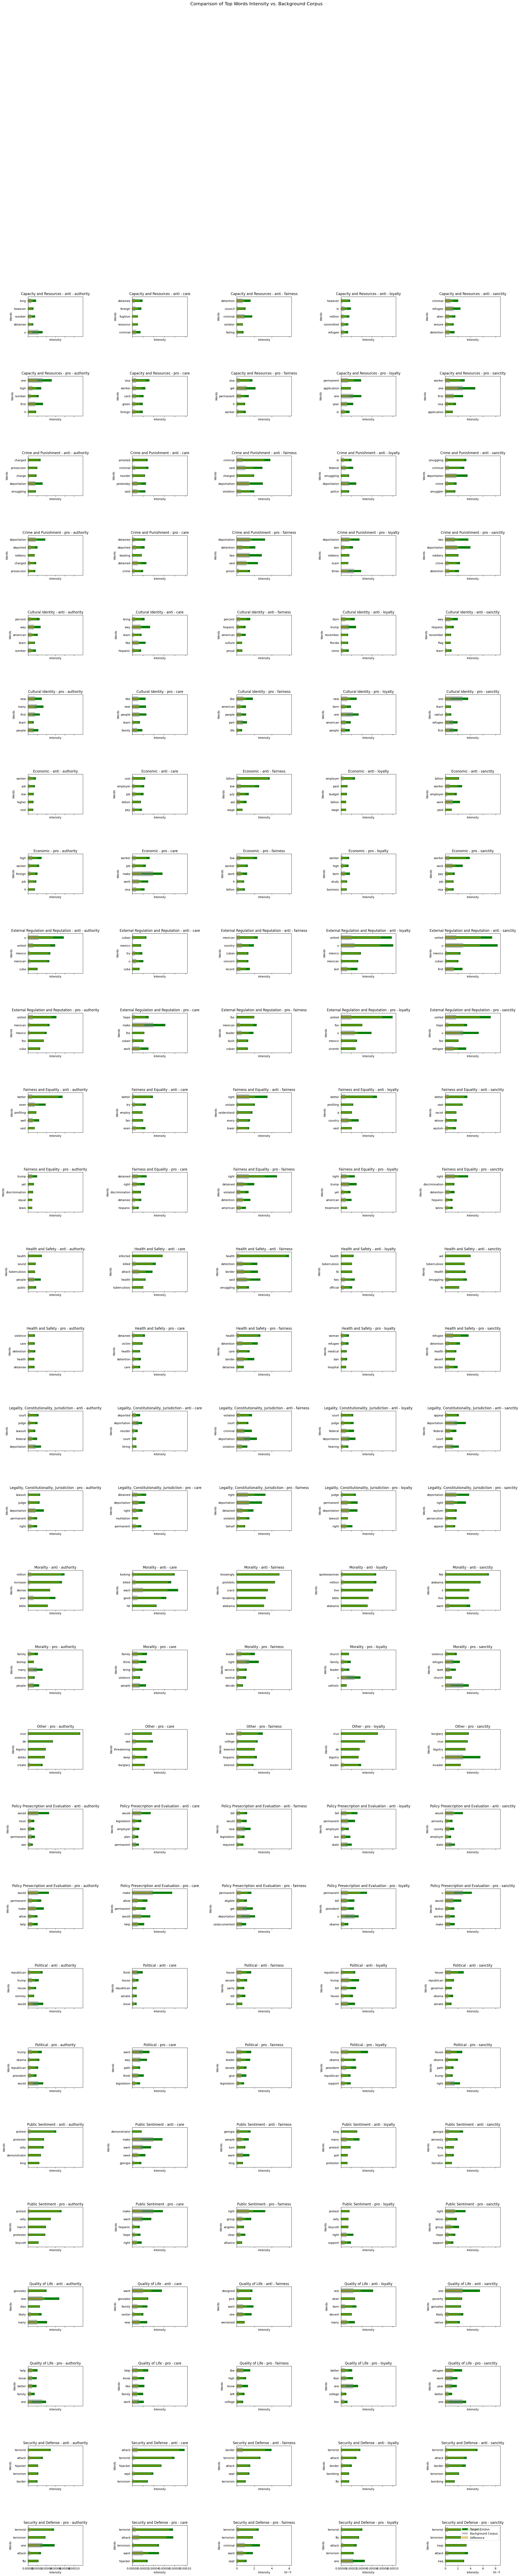

In [103]:
def plot_word_intensity_comparisons(df_intensity, df_background_shift_intensity, selected_document_frames, selected_microframes, group_by_col="frame_tone", top_n=10):
    df_merged = df_intensity.merge(df_background_shift_intensity, on=[group_by_col, 'word', 'microframe']).rename(columns={'intensity_shift': 'intensity_target'})

    # add intensity_difference
    df_merged['intensity_difference'] = df_merged['intensity_target'] - df_merged['intensity_background']
 
    # Plot setup
    num_document_frames = len(selected_document_frames)
    num_microframes = len(selected_microframes)
    fig, axes = plt.subplots(num_document_frames, num_microframes, figsize=(num_microframes * 6, num_document_frames * 5), sharex='col')
    fig.subplots_adjust(hspace=1.0, wspace=0.9)

    # Ensure axes are always in a 2D array format
    if num_document_frames == 1 and num_microframes == 1:
        axes = np.array([[axes]])
    elif num_document_frames == 1:
        axes = np.array([axes])
    elif num_microframes == 1:
        axes = axes[:, np.newaxis]

    # Plotting
    for frame_index, doc_frame in enumerate(selected_document_frames):
        for microframe_index, microframe in enumerate(selected_microframes):
            ax = axes[frame_index, microframe_index]

            # get top_words for the selected document frame and microframe
            top_words = df_merged[(df_merged[group_by_col] == doc_frame) & (df_merged['microframe'] == microframe)].nlargest(top_n, 'intensity_difference')

            # reverse the order of the top_words
            top_words = top_words.iloc[::-1]

            bar_width = 0.3

            # Plot target corpus intensityes
            ax.barh(top_words['word'], top_words['intensity_target'], height=bar_width, color='green', label='Target Corpus')

            # Plot background intensityes for these top words
            ax.barh(top_words['word'], top_words['intensity_background'], height=bar_width*2, color='gray', alpha=0.5, label='Background Corpus')

            # Plot difference
            ax.barh(top_words['word'], top_words['intensity_difference'], height=bar_width/2, color='orange', alpha=0.5, label='Difference')

            ax.set_title(f"{doc_frame} - {microframe}")
            ax.set_xlabel('Intensity')
            ax.set_ylabel('Words')

    # Legend handling
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.suptitle('Comparison of Top Words Intensity vs. Background Corpus', fontsize=16)
    plt.show()


selected_frame_tone = ['Capacity and Resources - anti',
 'Capacity and Resources - pro',
 'Crime and Punishment - anti',
 'Crime and Punishment - pro',
 'Cultural Identity - anti',
 'Cultural Identity - pro',
 'Economic - anti',
 'Economic - pro',
 'External Regulation and Reputation - anti',
 'External Regulation and Reputation - pro',
 'Fairness and Equality - anti',
 'Fairness and Equality - pro',
 'Health and Safety - anti',
 'Health and Safety - pro',
 'Legality, Constitutionality, Jurisdiction - anti',
 'Legality, Constitutionality, Jurisdiction - pro',
 'Morality - anti',
 'Morality - pro',
 'Other - pro',
 'Policy Presecription and Evaluation - anti',
 'Policy Presecription and Evaluation - pro',
 'Political - anti',
 'Political - pro',
 'Public Sentiment - anti',
 'Public Sentiment - pro',
 'Quality of Life - anti',
 'Quality of Life - pro',
 'Security and Defense - anti',
 'Security and Defense - pro']

selected_frames = ['Quality of Life', 'Legality, Constitutionality, Jurisdiction',
       'Capacity and Resources', 'Cultural Identity', 'Health and Safety',
       'Security and Defense', 'Economic', 'Crime and Punishment',
       'External Regulation and Reputation', 'Political',
       'Fairness and Equality', 'Policy Presecription and Evaluation',
       'Morality', 'Public Sentiment', 'Other']
selected_microframes = ['authority', 'care', 'fairness', 'loyalty', 'sanctity']

plot_word_intensity_comparisons(df_intensities, df_background_shift_intensity, selected_frame_tone, selected_microframes, group_by_col=group_by_col, top_n=5)

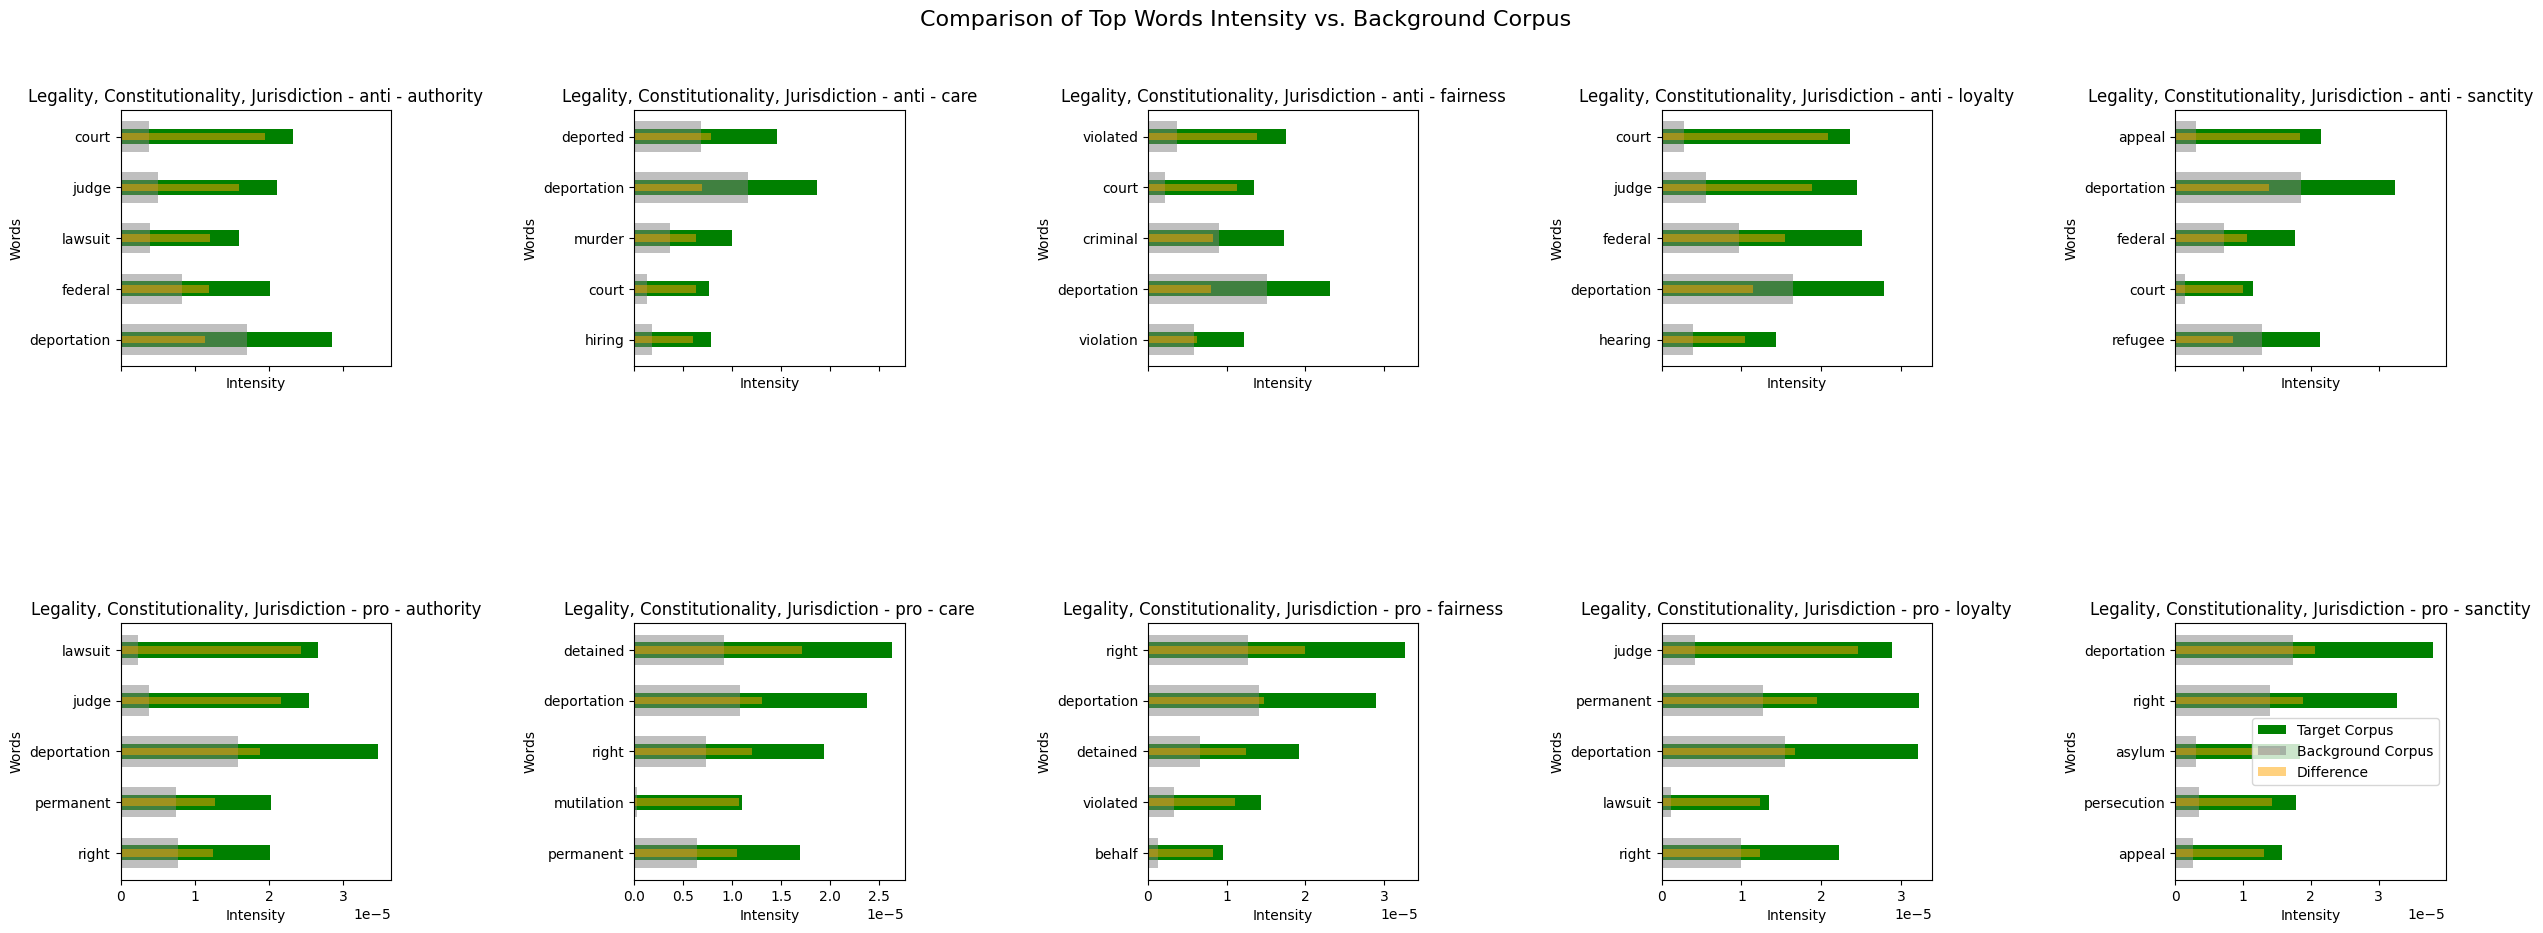

In [104]:
selected_frame_tone = ['Legality, Constitutionality, Jurisdiction - anti',
 'Legality, Constitutionality, Jurisdiction - pro',]

selected_frames = ['Quality of Life', 'Legality, Constitutionality, Jurisdiction',
       'Capacity and Resources', 'Cultural Identity', 'Health and Safety',
       'Security and Defense', 'Economic', 'Crime and Punishment',
       'External Regulation and Reputation', 'Political',
       'Fairness and Equality', 'Policy Presecription and Evaluation',
       'Morality', 'Public Sentiment', 'Other']
selected_microframes = ['authority', 'care', 'fairness', 'loyalty', 'sanctity']

plot_word_intensity_comparisons(df_intensities, df_background_shift_intensity, selected_frame_tone, selected_microframes, group_by_col=group_by_col, top_n=5)